# **Knowledge Distillation**

Francesco Marrocco

### ***0. Import dependencies and helper functions***

In [1]:
import glob
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import zipfile
from io import BytesIO
from IPython.display import Image
from sklearn import datasets as sk_datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

In [2]:
def load_model_from_github(model_class, url, device, input_size = 28*28):
    response = requests.get(url)
    response.raise_for_status()
    model = model_class(input_size)
    model.load_state_dict(torch.load(BytesIO(response.content), map_location=torch.device(device), weights_only=False))
    model.to(device)
    return model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### ***1. Introduction***

Starting from 2012 with AlexNet, neural networks have gained increasing relevance in both research and industry. A neural network, as is well known, is composed of an **input layer**, an arbitrary number of **hidden layers**, and an **output layer**. In the specific case of classifier networks, the input layer gathers information directly from the object to be classified, the hidden layers perform matrix operations, leading to a certain vector in the output layer with as many elements as the possible classes in the classification task. The prediction is made by observing the logits, which are the elements of the output vector, looking for the value with the highest softmax. Empirically, it has been understood that increasingly deeper networks can guarantee higher prediction accuracy. However, this comes with a downside: to achieve significant improvement, the network must be much deeper, requiring more time to train and occupying considerable memory space in PCs or servers. For this reason, various techniques have been developed to at least reduce the memory space used, making these networks more portable. Among these techniques, **Parameter pruning and sharing** is notable for focusing on removing non-essential parameters from hidden layers; **Low-rank factorization**, which removes redundant parameters; and **Knowledge distillation**, which seeks to transfer information from larger, already trained models to smaller models during training. Among the most relevant papers on Knowledge distillation is Hinton's 2015 paper, which popularized this term for this type of technique.

In [4]:
#@title 1. Example: CNN$^{11.5}$


url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/images_markdown/image_1.jpg'
Image(url=url, width = 900, height = 500)


Referring to how the class is established, consider a special case as shown in Figure 1. The image, with dimensions 28x28x1 (as will frequently be used in this notebook), is acquired from the input layer. In the hidden layers, matrix operations are performed in order to abstract the features. This process allows the neural network to generate more and more abstract representations, which do not depend on specific images, thus making it possible to correctly classify even previously unseen data. The end result of this process is an output vector whose length corresponds to the total number of possible classes in the classification.

The class attributed to the object is chosen from the output vector $x$ as follows:

- Softmax is applied to the vector $x$

$softmax(x)=[\frac{e^{x_0}}{\sum_i e^{x_i}}, \frac{e^{x_1}}{\sum_i e^{x_i}},..., \frac{e^{x_n}}{\sum_i e^{x_i}},]$

That is, the output vector is normalised in such a way that the sum of all elements is $1$ obtaining a probability distribution.

- The maximum value of $softmax(x)$ corresponding to the predicted class is chosen.

In [5]:
#@title 2. Visualization of prediction process $^{11.6}$


url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/images_markdown/softmax_visual.png'
Image(url=url, width = 900, height = 400)


In the example provided in Figure 2, the classifier is predicting dog with 71% certainity in the first row; horse with 98% in the second row and attributes the same probability to the third row for both dog and cat

Together with softmax it is common to use the **Negative Log-Likelihood (NLL)** defined as

$L(y) = -log(y_i)$

where $y_i$ is the probability that is assigned by $softmax(x)$ to the object at the i-th position knowing it to be the real value of the label. Thus the greater the confidence in predicting the correct class, the lower the loss.

In PyTorch the log_softmax and nll_loss are both performed by nn.CrossEntropyLoss which, operating from the logits, calculates the loss. As will be the case in this notebook the networks are trained on batches of the dataset and in that case the CrossEntropyLoss is:

$\mathcal{H}(y, \sigma(\mathbf{z})) = - \frac{1}{N}\sum_{i=1}^N\sum_{j=1}^{C} y_j \log\left(\frac{\exp(z_j)}{\sum_{i=1}^{C} \exp(z_i)}\right)$

$N=\text{batch size}$

$C=\text{number of classes}$

$y=\text{true labels vector}$

Therefore, since $y$ is always zero except for the true label the loss is (given $y_j = 1$)

$\mathcal{H}(\sigma(\mathbf{z})) = - \frac{1}{N}\sum_{j=1}^{N} \log\left(\frac{\exp(z_j)}{\sum_{i=1}^{C} \exp(z_i)}\right)$

The key to **Knowledge Distillation (KD)** lies in modifying this loss by adding a term. As previously mentioned, this technique consists of using a larger and more accurate model (professor/teacher) to transmit knowledge to a smaller and theoretically less accurate one (student).


Having the logits of the professor model as prior information, one can rewrite the loss by trying to both minimise the CrossEntropyLoss on the dataset and the distance between the two probability distributions provided as output by the models, using the Kullback-Leibler distance, defined as:

$D_{KL} (P||Q)= \sum_i P(i)log\frac{P(i)}{Q(i)}$

In the implementation, PyTorch greatly simplifies the use of $D_{KL}$, with the function `nn.KLDivLoss()` calculating the distance between the student's probabilities expressed through `log_softmax` and the teacher's probabilities with the classical `softmax`.The reason for this can be clearly seen if I rewrite $D_{KL}$ as follows:

$D_{KL} (P||Q)= \sum_i P(i) (log{P(i)}-log{Q(i)})$

Making it evident that P is used in both `softmax` and `log_softmax` while Q is used only in `log_softmax`.The loss of $D_{KL}$ is called the **soft loss** which differs from the **hard loss** which is the name given to the loss with respect to *true labels*.

Finally, I introduce two scalar terms that are of primary importance in the implementation of KD-based training algorithms, **temperature** and **$\alpha$**.

 $1.$ The **temperature** is a
term that modifies the distributions as follows and Figure 3 gives an easy interpretation.

$p_i = \frac{\exp\left(\frac{z_{s,i}}{T}\right)}{\sum_j \exp\left(\frac{z_{s,j}}{T}\right)}, \quad q_i = \frac{\exp\left(\frac{z_{t,i}}{T}\right)}{\sum_j \exp\left(\frac{z_{t,j}}{T}\right)}$

Where $z_s$ is the student's distribution and $z_t$ that of the teacher.

**Gradient of $D_{KL}$ with respect to the student's logits**.

After introducing the temperature I look at its effect on the calculated gradient with respect to the student's logits $\mathbf{z}_s$:

- I consider $P(i) = \sigma_i\left(\frac{\mathbf{z}_t}{\tau}\right)$ e $Q(i) = \sigma_i\left(\frac{\mathbf{z}_s}{\tau}\right)$.

- The softmax function can be differentiated as follows $^{11.8}$:

$\frac{\partial \sigma_i\left(\frac{z}{\tau}\right)}{\partial z_j} = \frac{1}{\tau} \sigma_i\left(\frac{z}{\tau}\right)\left(\delta_{ij} - \sigma_j\left(\frac{z}{\tau}\right)\right)\propto \frac{1}{\tau}$

- I now consider the gradient of the
 $D_{KL}$

$\frac{\partial}{\partial z_{s,i}} D_{KL}\left(\sigma\left(\frac{\mathbf{z}_t}{\tau}\right) \,\|\, \sigma\left(\frac{\mathbf{z}_s}{\tau}\right)\right)$

- To calculate this gradient we need the derivative of the logarithm

$\frac{\partial}{\partial z_{s,i}} \log \sigma_i\left(\frac{\mathbf{z}_s}{\tau}\right) = \frac{1}{\sigma_i\left(\frac{\mathbf{z}_s}{\tau}\right)} \cdot \frac{\partial \sigma_i\left(\frac{\mathbf{z}_s}{\tau}\right)}{\partial z_{s,i}} =  \frac{1}{\tau\cdot \sigma_i\left(\frac{\mathbf{z}_s}{\tau}\right)}  \cdot \sigma_i\left(\frac{\mathbf{z}_s}{\tau}\right)\left(1 - \sigma_i\left(\frac{\mathbf{z}_s}{\tau}\right)\right)\propto \frac{1}{\tau}
$

- The overall gradient of $D_{KL}$ is proportional to the term of the log_softmax and the softmax therefore:

$\frac{\partial}{\partial z_{s,i}} D_{KL}\left(\sigma\left(\frac{\mathbf{z}_t}{\tau}\right) \,\|\, \sigma\left(\frac{\mathbf{z}_s}{\tau}\right)\right) \propto \frac{1}{\tau} \cdot \frac{1}{\tau} = \frac{1}{\tau^2}$

This makes, in theory, the hard loss more influential in the calculation of the next step of the algorithm because the soft is scaled by this term. Therefore, in the final formula combining the two losses (hard and soft), the soft loss is multiplied by $\tau^2$ to counterbalance this effect


In [6]:
#@title 3. Effects of temperature on a random distribution $^{11.7}$

url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/images_markdown/temperature_effect.png'
Image(url=url, width = 900, height = 300)

$2.$ **Alpha** is a number between 0 and 1 that determines the importance given to each of the two losses in the calculation of the overall loss

The overall distillation loss then is:

$\mathcal{L}_{\text{distill}} = \alpha \cdot \tau^2 \cdot D_{KL}\left(P\left(\frac{\mathbf{z}_t}{\tau}\right) \,\middle\|\, Q\left(\frac{\mathbf{z}_s}{\tau}\right)\right) + (1 - \alpha) \cdot \mathcal{H}(\mathbf{y}, \sigma(\mathbf{z}_s))$

Now with many elements at our disposal we can begin the case study of KD but not before defining 4 variables that recur throughout the notebook and with which it is essential to familiarise ourselves for a complete understanding of the document.

 - **trained_models:** determines whether the models and networks that will be used are to be trained already (by importing them from GitHub) or re-trained. Important: trained_models = False in this document can lead to very long executions: the whole notebook would take about 100 hours. It is strongly recommended not to change this option except for quick tests; after all, the results would be identical, as the whole notebook is always seeded at the start of the codes.

 - **saved_results:** determines whether to import results from json files saved on GitHub; this is also recommended to keep it True as model tests take minutes and the notebook would take about 30 minutes/1 hour to run in full.

 - **import_models:** is an option unrelated to saved_results that allows you to still import models but use jsons to access test results if saved_results is set to True

 - **save_jsons:** allows jsons with results to be saved locally

 Finally, it is recommended to execute all the code in order as in many cases the same variables are taken after paragraphs.

In [7]:
trained_models = True
saved_results = True
import_models = False
save_jsons = False

### ***2. Knowledge Distillation***

As mentioned in the introduction, with Knowledge Distillation, an attempt is made to transmit acquired knowledge from a larger and more precise model to a smaller and less precise one. In the article *Knowledge Distillation: A Survey* (Gou, Yu, Maybank, Tao; 2021), various methods and potential improvements of this process are extensively discussed concerning:

1. Which information from the teacher model is used as a knowledge parameter and thus passed on to the student (sec 2)
2. Who is the teacher and who the student (sec 3)

3. Various KD algorithms (sec 5)

In [8]:
#@title 4. Structure of the article by Gou, Yu, Maybank, Tao$^{11.1}$

url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/images_markdown/kd_overview.png'
Image(url=url, width = 900, height = 450)

These are specifically the sections I will explore in this notebook.

In terms of what teacher information is considered, there are instances of:

- Response-Based Knowledge: Which calculates the $\mathcal{L}_{\text{distill}}$ based solely on logits

- Feature-Based Knowledge: Which calculates $\mathcal{L}_{\text{distill}}$ based also on intermediate representations. In particular, in this notebook, this type of knowledge will be sought in the case of network training via Self-Distillation

- Relation-Based Knowledge: This will not be seen in the notebook but consists of using, instead of some kind of logits (intermediate representations can also be seen as logits in one sense), the relations between the various layers

In [9]:
 #@title 5. Types of knowledge $^{11.1}$

url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/images_markdown/knowledges.png'
Image(url=url, width = 800, height = 500)

Moving on from the ‘types of knowledge’ I now focus on which model to choose as a teacher and which as a student. In fact, it is not always obvious or guaranteed to have a teacher and a student. The article ‘Knowledge Distillation: A Survey’ identifies 3 situations:

- Offline Distillation: The classic one consisting of teacher and student with the teacher already trained

- Online Distillation: Also here teacher and student are present but both are to be trained (or at least the teacher continues to train even if he has already received some prior training). It will not, however, be studied with examples in this notebook.

- Self Distillation: In this case teacher and student coincide in a model that uses intermediate logits as the origin of the $\mathcal{L}_{\text{distill}}$

In [10]:
 #@title 6. Teacher-student relation $^{11.1}$

url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/images_markdown/types_of_teachers.png'
Image(url=url, width = 400, height = 350)

Finally, one type of possible algorithm is Multi Teacher Knowledge Distillation (MTKD), where instead of using one teacher, one chooses to use many, theoretically increasing the quality of information passed as soft loss.


In [11]:
 #@title 7. Multi-Teacher Knowledge Distillation$^{11.1}$

url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/images_markdown/MTKD.png'
Image(url=url, width = 900, height = 450)

MTKD and Self-Distillation will be given more attention in the dedicated paragraphs. I will now begin with a simple study of KD algorithms with teachers of various types

### ***3. DecisionTreeClassifier***

A first simple example of KD. First, I initialise a seed to make everything reproducible. I specify that everything has been trained and implemented in Google Colab, so there may be slight differences on other versions, but by importing the files from the dedicated GitHub everything becomes identical.

In [12]:
torch.manual_seed(0)

For this case I use sklearn's Iris dataset, an example of which I give below. Note that it is not a dataset of images but of 4 numerical values identifying a flower, and the task of the algorithms is to associate each list with the corresponding flower.

[6.3 3.3 6.  2.5]


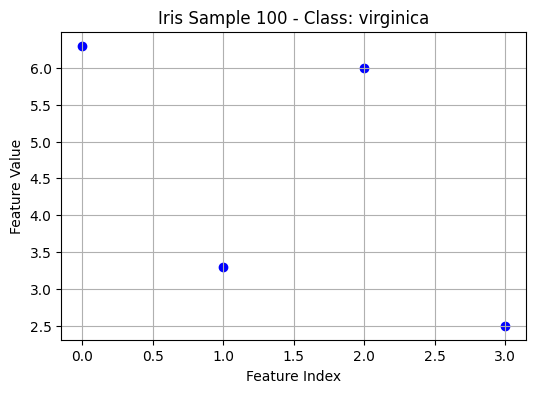

Random Sample Features: [6.3 3.3 6.  2.5]
Corresponding Label: virginica


In [13]:
#@title Iris Dataset

iris = sk_datasets.load_iris()

sample = iris.data[100]
label = iris.target[100]
print(sample)

plt.figure(figsize=(6, 4))
plt.scatter(range(len(sample)), sample, c='blue', marker='o')
plt.title(f'Iris Sample {100} - Class: {iris.target_names[label]}')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.grid(True)
plt.show()

print(f'Random Sample Features: {sample}')
print(f'Corresponding Label: {iris.target_names[label]}')

In [14]:
#@title Data preparation

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Defining the teacher model. Here I use sklearn's version of `DecisionTreeClassifier()`, and check its accuracy through the `.score()` method. I find this useful as a first test, since it is a completely non-neural structure. Although this may seem absurd since a decision tree has no logits for distillation loss, sklearn with the method `.preict_proba()` provides a practically equivalent solution to extracting logits from a model.


In [15]:
teacher_model1 = DecisionTreeClassifier()
teacher_model1.fit(X_train, y_train)

teacher_accuracy = 100 * teacher_model1.score(X_test, y_test)
print(f'Teacher Model Accuracy: {teacher_accuracy:.2f}%')

teacher_logits = teacher_model1.predict_proba(X_train)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
teacher_logits_tensor = torch.tensor(teacher_logits, dtype=torch.float32)

Teacher Model Accuracy: 100.00%


Let's now take a look at the elements that will be used as training sets thanks to the batch division operated by the DataLoader

In [16]:
#@title Dataloader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor, teacher_logits_tensor)
train_loader_iris = DataLoader(train_dataset, batch_size=16, shuffle=True)

for batch in train_loader_iris:
    X_batch, y_batch, teacher_logits_batch = batch
    print("X_batch (features):\n", X_batch)
    print("\ny_batch (labels):\n", y_batch)
    print("\nteacher_logits_batch (logits from teacher):\n", teacher_logits_batch)
    break

X_batch (features):
 tensor([[-1.7486,  0.3410, -1.4154, -1.3362],
        [-0.2135, -0.3565,  0.2161,  0.0885],
        [ 1.2034,  0.1085,  0.8913,  1.1246],
        [-0.0954, -0.8215,  0.7225,  0.8656],
        [-0.9220,  1.7360, -1.2466, -1.3362],
        [ 0.0226,  0.3410,  0.5537,  0.7361],
        [-1.5124,  0.1085, -1.3029, -1.3362],
        [ 0.1407, -1.9840,  0.6662,  0.3475],
        [-1.0401,  0.3410, -1.4717, -1.3362],
        [ 0.3769, -1.9840,  0.3849,  0.3475],
        [-0.9220,  0.5735, -1.1904, -0.9476],
        [-0.4497, -1.2865,  0.1036,  0.0885],
        [-0.5678,  1.5035, -1.3029, -1.3362],
        [-1.0401,  1.0385, -1.2466, -0.8181],
        [-0.4497, -1.5190, -0.0089, -0.1705],
        [-0.3316, -0.8215,  0.2161,  0.0885]])

y_batch (labels):
 tensor([0, 1, 2, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 1, 1])

teacher_logits_batch (logits from teacher):
 tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [

I immediately notice an important feature. The probabilities created by `.preict_proba()` are very strong: in no case do I observe probabilities, in what I could define as the logits of the model (to which softmax has already been applied, however), lower than 1. This leads me to suppose a strong help that this model will be able to give to the students in the training phase.

I now define the student model, a very small neural network consisting only of an input, a hidden and an output layer. I also define two instances with which I first test the KD

In [17]:
class StudentNet(nn.Module):
    def __init__(self, input_size = 4):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

student_model_no_kd_non_neural_0 = StudentNet()
student_model_with_kd_non_neural_0 = StudentNet()

In [18]:
#@title Training and testing functions for Iris Dataset

def distillation_loss(student_logits, teacher_logits, targets, alpha=0.5, temperature=2.0):
    soft_targets = nn.functional.softmax(teacher_logits / temperature, dim=1)
    soft_student_logits = nn.functional.log_softmax(student_logits / temperature, dim=1)
    distillation_loss = nn.functional.kl_div(soft_student_logits, soft_targets, reduction='batchmean') * (temperature ** 2)
    hard_loss = nn.functional.cross_entropy(student_logits, targets)
    return alpha * distillation_loss + (1 - alpha) * hard_loss

def train_student_model1(model, use_kd=False, num_epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets, teacher_logits in train_loader_iris:
            optimizer.zero_grad()
            student_logits = model(inputs)
            if use_kd:
                loss = distillation_loss(student_logits, teacher_logits, targets)
            else:
                loss = nn.functional.cross_entropy(student_logits, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader_iris.dataset)

def test1(student_model_no_kd, X_test, y_test):
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        student_logits_test_no_kd = student_model_no_kd(X_test_tensor)
        student_predictions_no_kd = torch.argmax(student_logits_test_no_kd, dim=1).numpy()
        student_accuracy_no_kd = 100 * (student_predictions_no_kd == y_test).mean()
    return student_accuracy_no_kd

With the functions defined above, I do a quick test by training the two previously defined instances using the normal training algorithm in the first case and training with KD in the second.

In [19]:
#@title Test of the 2 models

if not saved_results:
    train_student_model1(student_model_no_kd_non_neural_0, use_kd=False)
    train_student_model1(student_model_with_kd_non_neural_0, use_kd=True, num_epochs=50)

    student_accuracy_no_kd_0 = test1(student_model_no_kd_non_neural_0, X_test, y_test)
    student_accuracy_with_kd_0 = test1(student_model_with_kd_non_neural_0, X_test, y_test)

    print(f"Student Model Accuracy without KD: {student_accuracy_no_kd_0:.2f}%")
    print(f'Student Model Accuracy with KD: {student_accuracy_with_kd_0:.2f}%')
else:
    json_url = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/dt1.json"
    try:
        response = requests.get(json_url)
        nnkd = response.json()
        print(f"Student Model Accuracy without KD: {nnkd['no_kd']}%")
        print(f"Student Model Accuracy with KD: {nnkd['kd']}%")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching JSON: {e}")

Student Model Accuracy without KD: 83.33%
Student Model Accuracy with KD: 73.33%


KD did not improve accuracy... But maybe this is a special case? I will test with many more models to see if it is a case

In [20]:
#@title 100 iterations

student_no_kd = 0
student_with_kd = 0
models_non_neural_no_KD = []
models_non_neural_with_KD = []
num_iterations = 101
if not saved_results:
    results_no_KD = {}
    results_KD = {}

    if not trained_models:
        for _ in range(num_iterations):
            torch.manual_seed(_)
            student_model_no_kd = StudentNet()
            student_model_with_kd = StudentNet()
            X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=_)
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            train_student_model1(student_model_no_kd, use_kd=False)
            student_accuracy_no_kd = test1(student_model_no_kd, X_test, y_test)
            student_no_kd += student_accuracy_no_kd
            torch.save(student_model_no_kd.state_dict(), f'student_model_no_kd_non_neural_{_}.pth')

            train_student_model1(student_model_with_kd, use_kd=True)
            student_accuracy_with_kd = test1(student_model_with_kd, X_test, y_test)
            student_with_kd += student_accuracy_with_kd
            torch.save(student_model_with_kd.state_dict(), f'student_model_with_kd_non_neural_{_}.pth')

            with zipfile.ZipFile('non_neural_models.zip', 'a') as zipf:
                zipf.write(f'student_model_no_kd_non_neural_{_}.pth')
                zipf.write(f'student_model_with_kd_non_neural_{_}.pth')

            results_no_KD[_] = student_accuracy_no_kd
            results_KD[_] = student_accuracy_with_kd

            if import_models:
                models_non_neural_no_KD.append(student_model_no_kd)
                models_non_neural_with_KD.append(student_model_with_kd)

    else:
        for i in range(num_iterations):
            torch.manual_seed(i)
            X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=i)
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            student_model_no_kd = load_model_from_github(StudentNet, f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/non_neural_models/student_model_no_kd_non_neural_{i}.pth', device, 4)
            acc1 = test1(student_model_no_kd, X_test, y_test)
            student_no_kd += acc1

            student_model_with_kd = load_model_from_github(StudentNet, f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/non_neural_models/student_model_with_kd_non_neural_{i}.pth', device, 4)
            acc2 = test1(student_model_with_kd, X_test, y_test)
            student_with_kd += acc2

            results_no_KD[i] = acc1
            results_KD[i] = acc2

            if import_models:
                models_non_neural_no_KD.append(student_model_no_kd)
                models_non_neural_with_KD.append(student_model_with_kd)

    if save_jsons:
        with open('Non_Neural_no_KD.json', 'w') as json_file:
            json.dump(results_no_KD, json_file, indent=4)
        with open('Non_Neural_with_KD.json', 'w') as json_file:
            json.dump(results_KD, json_file, indent=4)

else:
    url_no_kd = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/Non_Neural_no_KD.json'
    url_kd = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/Non_Neural_with_KD.json'

    response_no_kd = requests.get(url_no_kd)
    results_no_KD = json.loads(response_no_kd.text)

    response_kd = requests.get(url_kd)
    results_KD = json.loads(response_kd.text)

    student_no_kd = 0
    student_with_kd = 0

    for file, avg in results_no_KD.items():
        student_no_kd += avg

    for file, avg in results_KD.items():
        student_with_kd += avg

    if import_models:
        for i in range(num_iterations):
            nKD = load_model_from_github(StudentNet, f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/non_neural_models/student_model_no_kd_non_neural_{i}.pth', device, 4)
            wKD = load_model_from_github(StudentNet, f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/non_neural_models/student_model_with_kd_non_neural_{i}.pth', device, 4)
            models_non_neural_no_KD.append(nKD)
            models_non_neural_with_KD.append(wKD)

student_no_kd /= num_iterations
student_with_kd /= num_iterations

print(f'Student Model without KD Accuracy: {student_no_kd:.2f}%')
print(f'Student Model with KD Accuracy: {student_with_kd:.2f}%')


Student Model without KD Accuracy: 85.28%
Student Model with KD Accuracy: 86.50%


So yes, KD has indeed improved accuracy and by a lot, gaining more than 1% accuracy on a model that would already have had fairly high accuracy.

### ***4. Logistic regression models***

I now continue the study with logistical regression models. In this case I choose MNIST as a dataset consisting of 10 possible classes (numbers 1 to 10) and the objective of the classifier is to associate 28x28 pixel images of handwritten numbers with the corresponding class.

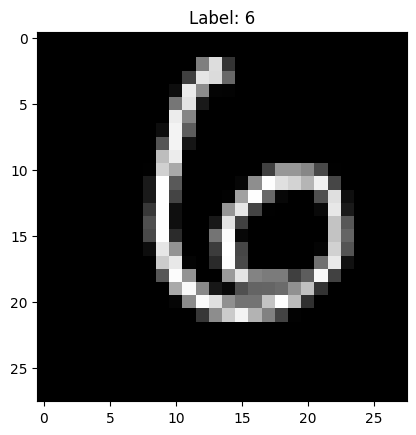

In [21]:
#@title MNIST

transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
image, label = mnist[100]
image = image.squeeze().numpy()

plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

I start, as always, by importing the dataset for the train and applying normalisation to it.

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

batch_size = 64
train_loaderMNIST = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loaderMNIST = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

I define slightly different training and testing functions than before, designed for larger models to provide more flexibility in training: instead of entering `teacher_logits` into the `DataLoader`, I have them calculated dynamically when needed. This will allow me more flexibility in the rest of the document by being able to use many different models as teachers.

Also, training by hard loss only and training by a combination of hard and soft loss is now done by 2 separate functions.

In [23]:
#@title New training e testing functions $^{11.4}$

def train(model, epochs, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

    return model

def test_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100 * correct / len(test_loader.dataset)
    print(f"Test Accuracy: {accuracy:.2f}%")
    return float(f"{accuracy:.2f}")

def train_student_model(teacher, student, train_loader, epochs = 10, alpha=0.5, T=2.0):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=0.001)

    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs)

            student_logits = student(inputs)
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)
            soft_targets_loss = nn.KLDivLoss()(soft_prob, soft_targets) * (T**2)
            label_loss = ce_loss(student_logits, labels)
            loss = alpha * soft_targets_loss + (1 - alpha) * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")

    return student


Now it is time to define the new model. In this case I define from scratch a logistic regression model that will serve me as both teacher and student. Since it is the same model, it is not obvious how to create a more experienced teacher.

In [24]:
class LogisticRegression(torch.nn.Module):

    def __init__(self, n_inputs = 28*28, n_outputs = 10):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
        self.n_inputs = n_inputs

    def forward(self, x):
        x = x.view(-1, self.n_inputs)
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

To overcome the problem described above, I train the teacher model on the dataset for 10 epochs while the student model for only one. In addition, as in the Decision Tree, I also train a model with only the hard loss as a baseline

In [25]:
#@title Training and testing logistic regression models

prefix_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/LogisticRegression/LogisticRegression'
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/LogisticRegression.json'

torch.manual_seed(0)

logistic_reg_models = []

if not saved_results:
    if not trained_models:

        teacher_model = LogisticRegression().to(device)
        student_model = LogisticRegression().to(device)
        baseline_model = LogisticRegression().to(device)

        teacher_model = train(teacher_model, 10, train_loaderMNIST)
        student_model = train_student_model(teacher_model, student_model, train_loaderMNIST, 1, 0.5, 2.0)
        baseline_model = train(baseline_model, 1, train_loaderMNIST)

        torch.save(teacher_model.state_dict(), 'LogisticRegressionTeacher.pth')
        torch.save(student_model.state_dict(), 'LogisticRegressionStudent.pth')
        torch.save(baseline_model.state_dict(), 'LogisticRegressionSmaller.pth')

        teacher_accuracy = test_model(teacher_model, test_loaderMNIST)
        student_accuracy = test_model(student_model, test_loaderMNIST)
        baseline_accuracy = test_model(baseline_model, test_loaderMNIST)

        with zipfile.ZipFile('LogisticRegression.zip', 'a') as zipf:
            zipf.write('LogisticRegressionTeacher.pth')
            zipf.write('LogisticRegressionStudent.pth')
            zipf.write('LogisticRegressionSmaller.pth')
    else:
        teacher_model = load_model_from_github(LogisticRegression, prefix_url+'Teacher.pth', device)
        student_model = load_model_from_github(LogisticRegression, prefix_url+'Student.pth', device)
        baseline_model = load_model_from_github(LogisticRegression, prefix_url+'Smaller.pth', device)

        teacher_accuracy = test_model(teacher_model, test_loaderMNIST)
        student_accuracy = test_model(student_model, test_loaderMNIST)
        baseline_accuracy = test_model(baseline_model, test_loaderMNIST)

    if save_jsons:
        try:
            with open('LogisticRegression.json', 'r') as json_file:
                data = json.load(json_file)
        except FileNotFoundError:
            data = {}

        if 'LogisticRegressionTeacher.pth' not in data:
            data['LogisticRegressionTeacher.pth'] = teacher_accuracy

        if 'LogisticRegressionStudent.pth' not in data:
            data['LogisticRegressionStudent.pth'] = student_accuracy

        if 'LogisticRegressionSmaller.pth' not in data:
            data['LogisticRegressionSmaller.pth'] = baseline_accuracy

            with open('LogisticRegression.json', 'w') as file:
                json.dump(data, file, indent=4)

    if import_models:
        logistic_reg_models.append(teacher_model)
        logistic_reg_models.append(student_model)
        logistic_reg_models.append(baseline_model)
else:
    try:
        response = requests.get(json_url)
        LogisticRegressionDict = response.json()
        print(f"Test accuracy teacher: {LogisticRegressionDict['LogisticRegressionTeacher.pth']}%")
        print(f"Test accuracy student: {LogisticRegressionDict['LogisticRegressionStudent.pth']}%")
        print(f"Test accuracy baseline: {LogisticRegressionDict['LogisticRegressionSmaller.pth']}%")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching JSON: {e}")

    if import_models:
        teacher_model = load_model_from_github(LogisticRegression, prefix_url+'Teacher.pth', device)
        student_model = load_model_from_github(LogisticRegression, prefix_url+'Student.pth', device)
        baseline_model = load_model_from_github(LogisticRegression, prefix_url+'Smaller.pth', device)
        logistic_reg_models.append(teacher_model)
        logistic_reg_models.append(student_model)
        logistic_reg_models.append(baseline_model)

Test accuracy teacher: 90.88%
Test accuracy student: 89.18%
Test accuracy baseline: 88.46%


So again, KD has improved accuracy. I will now proceed with the study with deep neural models, with more hidden layers than we have seen so far.

### ***5. Teacher: Small MLP***

In [26]:
torch.manual_seed(0)

After setting the seed to ensure reproducibility, I import the fashionMNIST dataset, a different dataset to the previous one with slightly more complex images but with the characteristic, as with MNIST, that the channel is unique, i.e. the images are in black and white

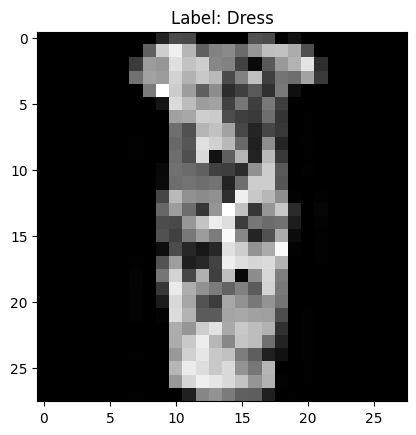

In [27]:
#@title fashionMNIST

transform = transforms.Compose([transforms.ToTensor()])
fashion_mnist = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
image, label = fashion_mnist[100]
image = image.squeeze().numpy()

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.imshow(image, cmap='gray')
plt.title(f'Label: {classes[label]}')
plt.show()

As usual, I import the dataset for training and normalise the data, then define dataloaders for training and testing

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

I now define the two neural models for the training of the smaller via KD. This time, the division between student and teacher is clear. In fact, although both models are MLPs, the former is much deeper and this guarantees, at least in theory, greater accuracy. But I verify:

In [29]:
class TeacherModel(nn.Module):
    def __init__(self, input_size = 28*28):
        super(TeacherModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


class StudentModel(nn.Module):
    def __init__(self, input_size = 28*28):
        super(StudentModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

first_mlp_models = []

For this code, it is recommended to set `import_models = True` in order to be able to check the number of parameters later.

In [30]:
import_models = True

In [31]:
#@title Training and testing TeacherModel

model_url = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/first_MLP_models/teacher_model_1_NN_42.pth"
json_url = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/First_MLP_Models.json"

if not saved_results:
    if not trained_models:
        torch.manual_seed(42)
        teacher_model = TeacherModel().to(device)
        teacher_model = train(teacher_model, 10, train_loader)
        teacher_accuracy = test_model(teacher_model, test_loader)
        torch.save(teacher_model.state_dict(), f'teacher_model_1_NN_42.pth')

        with zipfile.ZipFile('first_MLP_models.zip', 'a') as zipf:
            zipf.write(f'teacher_model_1_NN_42.pth')

    else:
        teacher_model = load_model_from_github(TeacherModel, model_url, device)
        teacher_accuracy = test_model(teacher_model, test_loader)

    if save_jsons:
        try:
            with open('First_MLP_Models.json', 'r') as json_file:
                data = json.load(json_file)
        except FileNotFoundError:
            data = {}

        if 'teacher' not in data:
            data['teacher'] = teacher_accuracy

            with open('First_MLP_Models.json', 'w') as file:
                json.dump(data, file, indent=4)

    if import_models:
            first_mlp_models.append(teacher_model)
else:
    try:
        response = requests.get(json_url)
        results_first_MLP = response.json()
        print(f"Test accuracy: {results_first_MLP['teacher']}%")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching JSON: {e}")
    if import_models:
        teacher_model = load_model_from_github(TeacherModel, model_url, device)
        first_mlp_models.append(teacher_model)

Test accuracy: 87.28%


In [32]:
#@title Training and testing StudentModel w/o KD

model_url = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/first_MLP_models/smaller_model_1_NN_42.pth"
json_url = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/First_MLP_Models.json"

if not saved_results:
    if not trained_models:
        torch.manual_seed(42)
        smaller_model = StudentModel().to(device)
        smaller_model = train(smaller_model, 10, train_loader)
        smaller_accuracy = test_model(smaller_model, test_loader)
        torch.save(smaller_model.state_dict(), f'smaller_model_1_NN_42.pth')

        with zipfile.ZipFile('first_MLP_models.zip', 'a') as zipf:
            zipf.write(f'smaller_model_1_NN_42.pth')

    else:
        smaller_model = load_model_from_github(StudentModel, model_url, device)
        smaller_accuracy = test_model(smaller_model, test_loader)
    if save_jsons:
        try:
            with open('First_MLP_Models.json', 'r') as json_file:
                data = json.load(json_file)
        except FileNotFoundError:
            data = {}
        if 'smaller' not in data:
            data['smaller'] = smaller_accuracy

            with open('First_MLP_Models.json', 'w') as file:
                json.dump(data, file, indent=4)

    if import_models:
            first_mlp_models.append(smaller_model)
else:
    try:
        response = requests.get(json_url)
        results_first_MLP = response.json()
        print(f"Test accuracy: {results_first_MLP['smaller']}%")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching JSON: {e}")
    if import_models:
        smaller_model = load_model_from_github(StudentModel, model_url, device)
        first_mlp_models.append(smaller_model)

Test accuracy: 86.0%


In [33]:
#@title Training and testing StudentModel with KD

model_url = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/first_MLP_models/student_model_1_NN_42.pth"
json_url = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/First_MLP_Models.json"

if not saved_results:
    if not trained_models:
        torch.manual_seed(42)
        student_model = StudentModel().to(device)
        student_model = train_student_model(student_model, 10, train_loader)
        student_accuracy = test_model(student_model, test_loader)
        torch.save(student_model.state_dict(), 'student_model_1_NN_42.pth')

        with zipfile.ZipFile('student_MLP_models.zip', 'a') as zipf:
            zipf.write('student_model_1_NN_42.pth')
    else:
        student_model = load_model_from_github(StudentModel, model_url, device)
        student_accuracy = test_model(student_model, test_loader)

    if save_jsons:
        try:
            with open('First_MLP_Models.json', 'r') as json_file:
                data = json.load(json_file)
        except FileNotFoundError:
            data = {}

        if 'student' not in data:
            data['student'] = student_accuracy

            with open('First_MLP_Models.json', 'w') as file:
                json.dump(data, file, indent=4)

    if import_models:
            first_mlp_models.append(student_model)
else:
    try:
        response = requests.get(json_url)
        results_first_MLP = response.json()
        print(f"Test accuracy: {results_first_MLP['student']}%")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching JSON: {e}")

    if import_models:
        student_model = load_model_from_github(StudentModel, model_url, device)
        first_mlp_models.append(student_model)

Test accuracy: 85.95%


In [34]:
import_models = False

With the training of the 3 models finished, I first check that the number of parameters of the two small models is the same and that it is, at the same time, lower than that of the teacher. I am fairly certain of this as I have defined them, but it is interesting to check again and have a comparison with reality

In [35]:
teacher = first_mlp_models[0]
smaller = first_mlp_models[1]
student = first_mlp_models[2]

total_params_deep = "{:,}".format(sum(p.numel() for p in teacher.parameters()))
print(f"TeacherModel: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in smaller.parameters()))
print(f"StudentModel without KD: {total_params_light}")
total_params_dist = "{:,}".format(sum(p.numel() for p in student.parameters()))
print(f"StudentModel with KD: {total_params_dist}")

TeacherModel: 575,050
StudentModel without KD: 25,450
StudentModel with KD: 25,450


I will now summarise the 3 training results.

In [36]:
if not saved_results:
    results_first_MLP = {'teacher': teacher_accuracy, 'smaller': smaller_accuracy, 'student': student_accuracy}
print(f"TeacherModel accuracy: {results_first_MLP['teacher']:.2f}%")
print(f"StudentModel w/o KD accuracy: {results_first_MLP['smaller']:.2f}%")
print(f"StudentModel with KD accuracy: {results_first_MLP['student']:.2f}%")

TeacherModel accuracy: 87.28%
StudentModel w/o KD accuracy: 86.00%
StudentModel with KD accuracy: 85.95%


In this case, the $\mathcal{L}_{\text{distill}}$ made the accuracy worse. But is this a case? Is there something that can be modified or changed? I try varying the values of $\alpha$ and $T$ and have 5 different networks trained, initialising the seeds from 0 to 4, and taking an average of the accuracies, to have a measure that is less dependent on the randomness of the network initialisation.

In [37]:
#@title Training with varying $\alpha$ and T


student_precision = []
models_a_T = []
prefix_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/finding_a_T'
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/Finding_a_T.json'
num_iterations = 5

alpha_values = [0.25, 0.5, 0.75]
temperature_values = [1.0, 2.0, 3.0]

for alpha in alpha_values:
    for temperature in temperature_values:
        for i in range(num_iterations):

            if not saved_results:
                if not trained_models:
                    torch.manual_seed(i)
                    student_model_distillated = StudentModel().to(device)
                    student_model_distillated = train_student_model(teacher_model, student_model_distillated, train_loader, epochs=10, alpha=alpha, T=temperature)
                    torch.save(student_model_distillated.state_dict(), f'model_{alpha}_{temperature}_{i}.pth')
                    student_distillated_accuracy = test_model(student_model_distillated, test_loader)
                    with zipfile.ZipFile('finding_a_T.zip', 'a') as zipf:
                        zipf.write(f'model_{alpha}_{temperature}_{i}.pth')
                else:
                    torch.manual_seed(i)
                    student_model_distillated = load_model_from_github(StudentModel, prefix_url+f'/model_{alpha}_{temperature}_{i}.pth', device)
                    student_distillated_accuracy = test_model(student_model_distillated, test_loader)

                if save_jsons:
                    try:
                        with open('Finding_a_T.json', 'r') as json_file:
                            data = json.load(json_file)
                    except FileNotFoundError:
                        data = {}
                    if f'{alpha}_{temperature}_{i}' not in data:
                        data[f'{alpha}_{temperature}_{i}'] = [student_distillated_accuracy, 1, alpha, temperature]

                        with open('Finding_a_T.json', 'w') as file:
                            json.dump(data, file, indent=4)

                student_precision.append([student_distillated_accuracy, 1, alpha, temperature])
                if import_models:
                    models_a_T.append(student_model)
            else:
                try:
                    response = requests.get(json_url)
                    results_a_T = response.json()
                    print(f"Test accuracy: {results_a_T[f'{alpha}_{temperature}_{i}'][0]}%")
                except requests.exceptions.RequestException as e:
                    print(f"Error fetching JSON: {e}")
                student_precision.append(results_a_T[f'{alpha}_{temperature}_{i}'])
                if import_models:
                    student_model = load_model_from_github(StudentModel, model_url, device)
                    models_a_T.append(student_model)


Test accuracy: 87.18%
Test accuracy: 86.66%
Test accuracy: 87.03%
Test accuracy: 86.54%
Test accuracy: 85.67%
Test accuracy: 86.88%
Test accuracy: 86.74%
Test accuracy: 86.8%
Test accuracy: 86.47%
Test accuracy: 85.13%
Test accuracy: 87.05%
Test accuracy: 86.64%
Test accuracy: 87.05%
Test accuracy: 86.23%
Test accuracy: 85.92%
Test accuracy: 86.88%
Test accuracy: 86.94%
Test accuracy: 87.15%
Test accuracy: 86.49%
Test accuracy: 85.44%
Test accuracy: 87.06%
Test accuracy: 86.55%
Test accuracy: 86.8%
Test accuracy: 86.15%
Test accuracy: 86.09%
Test accuracy: 86.77%
Test accuracy: 86.41%
Test accuracy: 86.49%
Test accuracy: 86.26%
Test accuracy: 85.79%
Test accuracy: 87.28%
Test accuracy: 87.05%
Test accuracy: 87.13%
Test accuracy: 85.69%
Test accuracy: 85.79%
Test accuracy: 87.33%
Test accuracy: 86.84%
Test accuracy: 86.64%
Test accuracy: 86.13%
Test accuracy: 86.5%
Test accuracy: 86.98%
Test accuracy: 86.48%
Test accuracy: 86.73%
Test accuracy: 86.37%
Test accuracy: 86.63%


But I also train 5 baseline models with $\alpha=0$ and $T=1$

In [38]:
#@title Baseline models

num_iterations = 5
prefix_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/finding_a_T'
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/Finding_a_T.json'

for i in range(num_iterations):
    if not saved_results:
        if not trained_models:
            torch.manual_seed(i)
            student_model = StudentModel().to(device)
            student_model = train(student_model, 10, train_loader)
            torch.save(student_model.state_dict(), f'model_{0.0}_{1.0}_{i}.pth')
            student_accuracy = test_model(student_model, test_loader)
            with zipfile.ZipFile('finding_a_T.zip', 'a') as zipf:
                zipf.write(f'model_0.0_1.0_{i}.pth')
        else:
            torch.manual_seed(i)
            student_model = load_model_from_github(StudentModel, prefix_url+f'/model_0.0_1.0_{i}.pth', device)
            student_accuracy = test_model(student_model, test_loader)

        if save_jsons:
            try:
                with open('Finding_a_T.json', 'r') as json_file:
                    data = json.load(json_file)
            except FileNotFoundError:
                data = {}

            if f'{0.0}_{1.0}_{i}' not in data:
                data[f'{0.0}_{1.0}_{i}'] = [student_accuracy, 1, 0.0, 1.0]

                with open('Finding_a_T.json', 'w') as file:
                    json.dump(data, file, indent=4)
        student_precision.append([student_accuracy, 1, 0.0, 1.0])
        if import_models:
            models_a_T.append(student_model)
    else:
        try:
            response = requests.get(json_url)
            results_a_T = response.json()
            print(f"Test accuracy: {results_a_T[f'0.0_1.0_{i}'][0]}%")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching JSON: {e}")
        student_precision.append(results_a_T[f'0.0_1.0_{i}'])
        if import_models:
            student_model = load_model_from_github(StudentModel, model_url, device)
            models_a_T.append(student_model)

Test accuracy: 87.06%
Test accuracy: 86.79%
Test accuracy: 86.78%
Test accuracy: 86.43%
Test accuracy: 85.34%


The accuracies obtained are many and difficult to understand without graphing them. To better understand what has been achieved, I illustrate them with a graph.

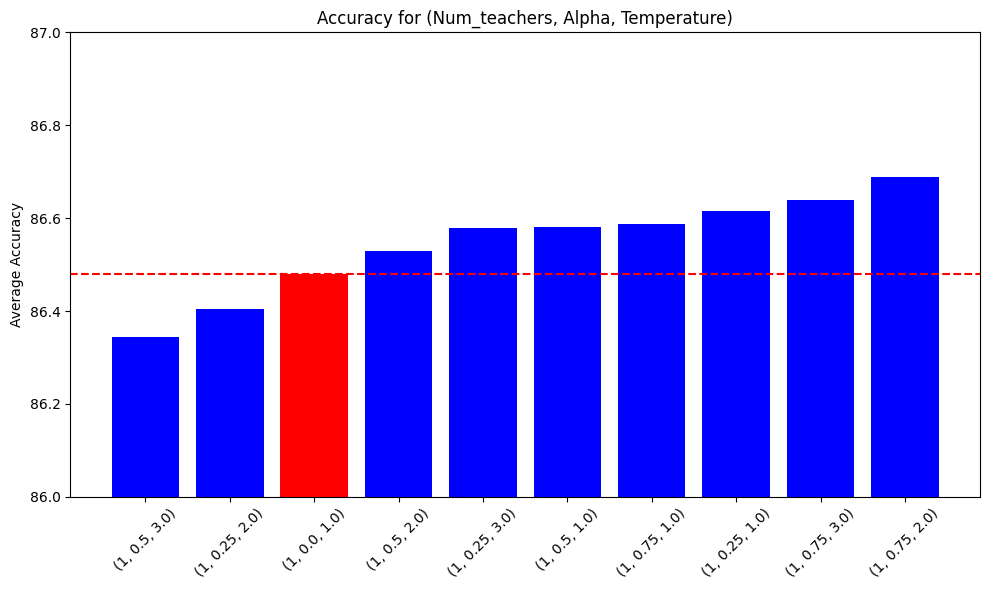

In [39]:
#@title Accuracies of models with varying $\alpha$ and T

counter = {}
counter_T_2 = {}

for el in student_precision:
    add = el[0] / num_iterations
    key = (el[1], el[2], el[3])
    if key not in counter:
        counter[key] = add
    else:
        counter[key] += add

    if el[3] == 2.0 or key == (1, 0.0, 1.0):
        if key not in counter_T_2:
            counter_T_2[key] = add
        else:
            counter_T_2[key] += add

counter = dict(sorted(counter.items(), key=lambda item: item[1]))
keys = list(counter.keys())
values = list(counter.values())

colors = ['red' if key == (1, 0.0, 1.0) else 'blue' for key in keys]

plt.figure(figsize=(10, 6))
plt.bar(range(len(values)), values, color=colors)

red_value = next((value for key, value in zip(keys, values) if key == (1, 0.0, 1.0)), None)
if red_value is not None:
    plt.axhline(y=red_value, color='red', linestyle='--', label=f'Red value: {red_value}')

plt.xticks(range(len(values)), [f'{key}' for key in keys], rotation=45)
plt.ylabel('Average Accuracy')
plt.title('Accuracy for (Num_teachers, Alpha, Temperature)')
plt.ylim(86, 87)
plt.tight_layout()
plt.show()

Thus, the general trend is to improve with the KD to the extent that each $\alpha$ and $T$ appears several times above the red baseline model.Even the $(1, 0.5, 2.0)$ tuple, which in the initial experiment seemed to have lower precision, is above the baseline.

I do not consider the order of the improvements extremely relevant, since they are minimal, but it is interesting to me how the models with $\alpha=0.75$ ranked massively above the baseline. Evidently the teacher's information is extremely useful for the models, so much so that they improve a lot by using 75% soft loss and 25% hard loss.

### ***6. Multi teacher KD***

I now begin the more in-depth case study of MTKD.

First of all, as previously mentioned, the application of KD via MTKD involves more than one teacher from which to extract logits. But even for this algorithm, there is more than one version. As explained in the article *Multi-teacher knowledge distillation as an effective method for compressing ensembles of neural networks* (Zuchniak; 2022), one can use the information of many teachers in at least 3 different ways.

- Prediction averaging: takes the average of the logits of all teachers as logits

- Mimic of prediction geometric centre: learns simultaneously from all teachers but loss also penalises getting too close to one teacher (moving away from others). This is why the model is said to reach the geometric centre of teacher prediction

- Independent mimicking of all the teachers: the model still learns from all the teachers simultaneously but does not look at the pure logits of the teachers, but those after softmax has been applied. By doing so, it is not penalised by logits with outliers that would move it towards the geometric centre but away from the optimal solution.

In this notebook I will experiment with the first and third techniques

In [40]:
#@title 8. MTKD algorithms $^{11.2}$
url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/images_markdown/types_of_MTKD.png'
Image(url=url, width = 600, height = 450)

I start the study by training 20 MLP TeacherModels (as defined in the previous section). These will be the teachers in at least this part of the work

In [41]:
#@title Training 20 TeacherModel
teachersMTKD = []
f_t = []
num_teachers = 20
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/MTKD_first_teachers.json'
for i in range(num_teachers):
    model_url = f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/MTKD/teacher_{i}.pth'
    if not saved_results:
        if not trained_models:
            torch.manual_seed(i)
            teacher = TeacherModel().to(device)
            teacher = train(teacher, 10, train_loader)
            torch.save(teacher.state_dict(), f'teacher_{i}.pth')
            with zipfile.ZipFile('MTKD.zip', 'a') as zipf:
                zipf.write(f'teacher_{i}.pth')

            teacher_accuracy = test_model(teacher, test_loader)
        else:
            torch.manual_seed(i)
            teacher = load_model_from_github(TeacherModel, model_url, device)
            teacher_accuracy = test_model(teacher, test_loader)
        f_t.append(teacher_accuracy)
        if save_jsons:
            try:
                with open('MTKD_first_teachers.json', 'r') as json_file:
                    data = json.load(json_file)
            except FileNotFoundError:
                data = {}
            if str(i) not in data:
                data[str(i)] = teacher_accuracy

                with open('MTKD_first_teachers.json', 'w') as file:
                    json.dump(data, file, indent=4)
        if import_models:
            teachersMTKD.append(teacher)
    else:
        try:
            response = requests.get(json_url)
            MTKD_first_teachers = response.json()
            print(f"Test accuracy: {MTKD_first_teachers[str(i)]}%")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching JSON: {e}")

        if import_models:
                teacher = load_model_from_github(TeacherModel, model_url, device)
                teachersMTKD.append(teacher)


Test accuracy: 88.27%
Test accuracy: 88.23%
Test accuracy: 87.95%
Test accuracy: 88.32%
Test accuracy: 88.13%
Test accuracy: 88.42%
Test accuracy: 88.61%
Test accuracy: 87.62%
Test accuracy: 88.47%
Test accuracy: 88.47%
Test accuracy: 88.5%
Test accuracy: 88.7%
Test accuracy: 88.3%
Test accuracy: 88.48%
Test accuracy: 88.28%
Test accuracy: 87.5%
Test accuracy: 88.45%
Test accuracy: 88.58%
Test accuracy: 88.09%
Test accuracy: 87.77%


In [42]:
#@title Prediction averaging training function

def train_student_model_multi_teacher(teachers, student, loader = train_loader, epochs = 10, alpha=0.5, T=2.0, device='cpu'):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=0.001)

    for teacher in teachers:
        teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            teacher_logits = []
            with torch.no_grad():
                for teacher in teachers:
                    teacher_logits.append(teacher(inputs))

            avg_teacher_logits = sum(teacher_logits) / len(teacher_logits)

            student_logits = student(inputs)
            soft_targets = nn.functional.softmax(avg_teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)
            soft_targets_loss = nn.KLDivLoss()(soft_prob, soft_targets) * (T**2)

            label_loss = ce_loss(student_logits, labels)

            loss = alpha * soft_targets_loss + (1 - alpha) * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(loader):.4f}")

    return student


I now train the models by varying only $\alpha$, unlike in the case of the single MLP teacher, but I retain the habit of training 5 of them and taking the average accuracy as a figure.

In [43]:
#@title Training students with varying $\alpha$

stored_students_MTKD_1 = []
num_teachers = [2, 5, 10, 20]
alphas = [0.25, 0.5, 0.75]
a_s = ['025', '05', '075']
num_iterations = 5
for_graph = []
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/MTKD_AVG.json'
for a in range(len(alphas)):
    for num in num_teachers:
        for i in range(num_iterations):
            prefix_url = f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/MTKD_students_{a_s[a]}'
            if not saved_results:
                if not trained_models:
                    torch.manual_seed(i)
                    student_model_distillated = StudentModel().to(device)
                    student_model_distillated = train_student_model_multi_teacher(teachersMTKD[:num], student_model_distillated, epochs=10, alpha=alphas[a], T=2.0)
                    student_distillated_accuracy = test_model(student_model_distillated, test_loader)
                    torch.save(student_model_distillated.state_dict(), f'MTKD_student{a_s[a]}_{num}_{i}.pth')
                    with zipfile.ZipFile(f'MTKD_students_{a_s[a]}.zip', 'a') as zipf:
                        zipf.write(f'MTKD_student{a_s[a]}_{num}_{i}.pth')
                else:
                    torch.manual_seed(i)
                    student_model_distillated = load_model_from_github(StudentModel, prefix_url+f'/MTKD_student{a_s[a]}_{num}_{i}.pth', device)
                    student_distillated_accuracy = test_model(student_model_distillated, test_loader)

                for_graph.append([student_distillated_accuracy, num, alphas[a], 2.0])

                if save_jsons:
                    try:
                        with open('MTKD_AVG.json', 'r') as json_file:
                            data = json.load(json_file)
                    except FileNotFoundError:
                        data = {}

                    key = f'{alphas[a]}_{num}_{i}'
                    if key not in data:
                        data[key] = [student_distillated_accuracy, num, alphas[a], 2.0]

                        with open('MTKD_AVG.json', 'w') as file:
                            json.dump(data, file, indent=4)
                if import_models:
                    stored_students_MTKD_1.append(student_model_distillated)

            else:
                try:
                    response = requests.get(json_url)
                    MTKD_AVG = response.json()
                    print(f"Test accuracy: {MTKD_AVG[f'{alphas[a]}_{num}_{i}'][0]}%")
                except requests.exceptions.RequestException as e:
                    print(f"Error fetching JSON: {e}")
                for_graph.append(MTKD_AVG[f'{alphas[a]}_{num}_{i}'])
                if import_models:
                    student_model = load_model_from_github(StudentModel, prefix_url+f'/MTKD_student{a_s[a]}_{num}_{i}.pth', device)
                    stored_students_MTKD_1.append(student_model)

Test accuracy: 86.98%
Test accuracy: 86.72%
Test accuracy: 86.96%
Test accuracy: 86.49%
Test accuracy: 85.33%
Test accuracy: 87.02%
Test accuracy: 86.72%
Test accuracy: 87.02%
Test accuracy: 86.39%
Test accuracy: 85.52%
Test accuracy: 87.14%
Test accuracy: 86.33%
Test accuracy: 86.77%
Test accuracy: 86.49%
Test accuracy: 85.77%
Test accuracy: 86.89%
Test accuracy: 86.67%
Test accuracy: 87.08%
Test accuracy: 85.77%
Test accuracy: 85.57%
Test accuracy: 87.12%
Test accuracy: 86.85%
Test accuracy: 87.22%
Test accuracy: 86.05%
Test accuracy: 85.72%
Test accuracy: 86.96%
Test accuracy: 87.02%
Test accuracy: 87.05%
Test accuracy: 86.16%
Test accuracy: 85.55%
Test accuracy: 87.21%
Test accuracy: 86.46%
Test accuracy: 87.27%
Test accuracy: 86.79%
Test accuracy: 85.73%
Test accuracy: 86.98%
Test accuracy: 86.76%
Test accuracy: 87.08%
Test accuracy: 86.07%
Test accuracy: 85.98%
Test accuracy: 86.79%
Test accuracy: 86.78%
Test accuracy: 86.51%
Test accuracy: 86.79%
Test accuracy: 86.0%
Test accura

As in the previous case, graph the results obtained to better understand them.

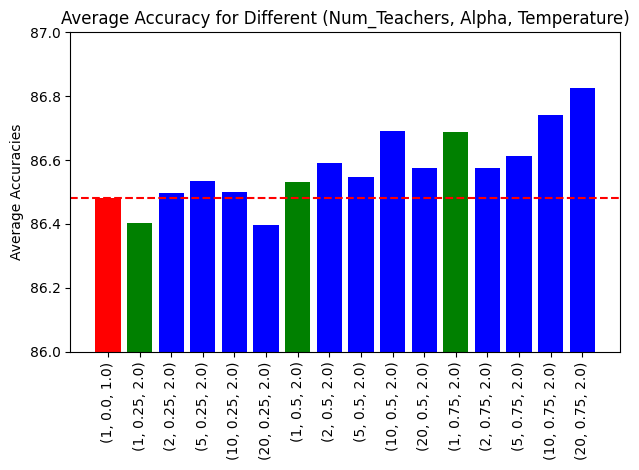

In [44]:
#@title Students' accuracies

counter = {}

for el in for_graph:
    add = el[0]/num_iterations
    if (el[1], el[2], el[3]) not in counter:
        counter[(el[1], el[2], el[3])] = add
    else:
        counter[(el[1], el[2], el[3])] += add

keys1 = list(counter.keys())
values1 = list(counter.values())
keys2 = list(counter_T_2.keys())
values2 = list(counter_T_2.values())

combined = list(zip(keys1, values1, ['blue'] * len(keys1))) + list(zip(keys2, values2, ['red' if key == (1, 0.0, 1.0) else 'green' for key in keys2]))
combined_sorted = sorted(combined, key=lambda x: (x[0][1], x[0][0]))
keys_sorted, values_sorted, colors_sorted = zip(*combined_sorted)
labels_sorted = [str(key) for key in keys_sorted]
x_positions = np.arange(len(keys_sorted))

plt.bar(x_positions, values_sorted, color=colors_sorted)
red_value = next((value for key, value, color in combined_sorted if color == 'red'), None)
if red_value is not None:
    plt.axhline(y=red_value, color='red', linestyle='--', label=f'Red value: {red_value}')
plt.xticks(x_positions, labels_sorted, rotation=90)
plt.ylabel('Average Accuracies')
plt.title('Average Accuracy for Different (Num_Teachers, Alpha, Temperature)')
plt.ylim(86, 87)
plt.tight_layout()
plt.show()

In the graph, the model in red is the baseline, the one with one teacher and $\alpha=0$ and $T=1$ while the greens are the models with only one teacher that compare with the models trained by several teachers with $\alpha$ fixed.

As can be seen, there is a general improvement in accuracy particularly in the models with $5$ and $10$ teachers; in fact, only in the case of $\alpha=0.75$ is there a constant improvement as the number of teachers increases.

Although this is not the behaviour I would generally expect, since as the number of teachers increases I should provide more and more truthful and useful data, I also feel that over-information and potential floating point errors when starting to deal with data quantities of this magnitude may have damaged the quality of the information.

Therefore, the logits that are passed to the algorithm may lose quality as the teachers increase, particularly after $10$.

I now introduce the second algorithm, the Independent mimicking of all the teachers, and perform the same operations as the Prediction Averaging algorithm, and then compare the results.

In [45]:
#@title Independent mimicking of all the teacher training function

def train_student(teachers, student, temperature, alpha, epochs):
    optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
    criterion_ce = nn.CrossEntropyLoss()
    criterion_kld = nn.KLDivLoss(reduction='batchmean')
    student.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            kld_loss = 0
            for teacher in teachers:
                teacher.eval()
                with torch.no_grad():
                    teacher_logits = teacher(images) / temperature
                    teacher_softmax = F.softmax(teacher_logits, dim=1)
                    student_logits = student(images) / temperature
                    student_log_softmax = F.log_softmax(student_logits, dim=1)
                    kld_loss += criterion_kld(student_log_softmax, teacher_softmax)
            kld_loss /= len(teachers)

            student_logits = student(images)
            ce_loss = criterion_ce(student_logits, labels)

            loss = alpha * kld_loss * (temperature ** 2) + (1 - alpha) * ce_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    return student

In [46]:
#@title Training students with this function

stored_students_MTKD_2 = []
num_teachers = [2, 5, 10, 20]
alphas = [0.25, 0.5, 0.75]
a_s = ['025', '05', '075']
num_iterations = 5
for_graph_2 = []
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/MTKD_2.json'
for a in range(len(alphas)):
    for num in num_teachers:
        for i in range(num_iterations):
            prefix_url = f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/MTKD_2_students_{a_s[a]}'
            if not saved_results:
                if not trained_models:
                    torch.manual_seed(i)
                    student_model_distillated = StudentModel().to(device)
                    student_model_distillated = train_student(teachersMTKD[:num], student_model_distillated, epochs=10, alpha=alphas[a], T=2.0)
                    student_distillated_accuracy = test_model(student_model_distillated, test_loader)
                    torch.save(student_model_distillated.state_dict(), f'MTKD_2_student{a_s[a]}_{num}_{i}.pth')
                    with zipfile.ZipFile(f'MTKD_2_students_{a_s[a]}.zip', 'a') as zipf:
                        zipf.write(f'MTKD_2_student{a_s[a]}_{num}_{i}.pth')
                else:
                    torch.manual_seed(i)
                    student_model_distillated = load_model_from_github(StudentModel, prefix_url+f'/MTKD_2_student{a_s[a]}_{num}_{i}.pth', device)
                    student_distillated_accuracy = test_model(student_model_distillated, test_loader)

                for_graph_2.append([student_distillated_accuracy, num, alphas[a], 2.0])
                if save_jsons:
                    try:
                        with open('MTKD_2.json', 'r') as json_file:
                            data = json.load(json_file)
                    except FileNotFoundError:
                        data = {}

                    key = f'{alphas[a]}_{num}_{i}'
                    if key not in data:
                        data[key] = [student_distillated_accuracy, num, alphas[a], 2.0]

                        with open('MTKD_2.json', 'w') as file:
                            json.dump(data, file, indent=4)
                if import_models:
                    stored_students_MTKD_2.append(student_model_distillated)

            else:
                try:
                    response = requests.get(json_url)
                    MTKD_2 = response.json()
                    print(f"Test accuracy: {MTKD_2[f'2_{a_s[a]}_{num}_{i}'][0]}%")
                except requests.exceptions.RequestException as e:
                    print(f"Error fetching JSON: {e}")
                for_graph_2.append(MTKD_2[f'2_{a_s[a]}_{num}_{i}'])
                if import_models:
                    student_model = load_model_from_github(StudentModel, prefix_url+f'/MTKD_2_student{a_s[a]}_{num}_{i}.pth', device)
                    stored_students_MTKD_2.append(student_model)

Test accuracy: 87.16%
Test accuracy: 87.35%
Test accuracy: 87.0%
Test accuracy: 86.69%
Test accuracy: 86.84%
Test accuracy: 87.01%
Test accuracy: 86.61%
Test accuracy: 86.31%
Test accuracy: 86.52%
Test accuracy: 86.3%
Test accuracy: 86.45%
Test accuracy: 86.05%
Test accuracy: 85.93%
Test accuracy: 86.32%
Test accuracy: 85.91%
Test accuracy: 86.05%
Test accuracy: 85.98%
Test accuracy: 85.59%
Test accuracy: 86.11%
Test accuracy: 85.84%
Test accuracy: 86.9%
Test accuracy: 87.48%
Test accuracy: 87.13%
Test accuracy: 87.52%
Test accuracy: 87.15%
Test accuracy: 87.31%
Test accuracy: 87.43%
Test accuracy: 86.71%
Test accuracy: 86.44%
Test accuracy: 86.89%
Test accuracy: 86.75%
Test accuracy: 86.48%
Test accuracy: 86.49%
Test accuracy: 86.28%
Test accuracy: 86.44%
Test accuracy: 86.43%
Test accuracy: 86.05%
Test accuracy: 86.17%
Test accuracy: 85.78%
Test accuracy: 86.04%
Test accuracy: 86.12%
Test accuracy: 85.69%
Test accuracy: 85.81%
Test accuracy: 85.5%
Test accuracy: 85.74%
Test accuracy:

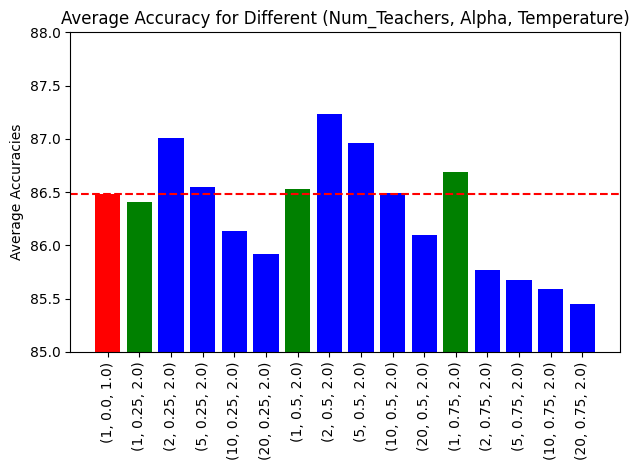

In [47]:
#@title Students' accuracies


counter_2 = {}

for el in for_graph_2:
    add = el[0]/num_iterations
    if (el[1], el[2], el[3]) not in counter_2:
        counter_2[(el[1], el[2], el[3])] = add
    else:
        counter_2[(el[1], el[2], el[3])] += add

keys1 = list(counter_2.keys())
values1 = list(counter_2.values())
keys2 = list(counter_T_2.keys())
values2 = list(counter_T_2.values())

combined = list(zip(keys1, values1, ['blue'] * len(keys1))) + list(zip(keys2, values2, ['red' if key == (1, 0.0, 1.0) else 'green' for key in keys2]))
combined_sorted = sorted(combined, key=lambda x: (x[0][1], x[0][0]))
keys_sorted, values_sorted, colors_sorted = zip(*combined_sorted)
labels_sorted = [str(key) for key in keys_sorted]

x_positions = np.arange(len(keys_sorted))

plt.bar(x_positions, values_sorted, color=colors_sorted)
red_value = next((value for key, value, color in combined_sorted if color == 'red'), None)

if red_value is not None:
    plt.axhline(y=red_value, color='red', linestyle='--', label=f'Red value: {red_value}')


plt.xticks(x_positions, labels_sorted, rotation=90)
plt.ylabel('Average Accuracies')
plt.title('Average Accuracy for Different (Num_Teachers, Alpha, Temperature)')
plt.ylim(85, 88)
plt.tight_layout()
plt.show()

What is assumed in the case of the Prediction Averaging algorithm becomes blatant in my opinion. Here with fewer teachers, there is a massive improvement in accuracy (more than $0.5$% compared to models with only one teacher) but this decreases as the number of teachers increases. This confirms to me again and again that too many teachers damage information, especially if they are equal teachers. In fact, in the latter case, calculating $D_{KL}$ for $20$ times (in the case of the $20$ teachers) is not only computationally heavy, but also incurs larger and larger floating point errors. In the case of prediction averaging the $D_{KL}$ is evaluated once with the average logits whereas in this case it is calculated once per teacher. I therefore believe that too many operations make one lose precision rather than provide useful information.

A separate case is that for models with $\alpha=0.75$. For the first time so far, over-reliance on teachers has damaged the performance of the models. This, however, supports the thesis that too many teachers may have caused the models to lose information rather than provide it.

I now graph the results obtained from both versions of training algorithms with MTKD, keeping only the best accuracy for each (num_teachers, alpha, T).

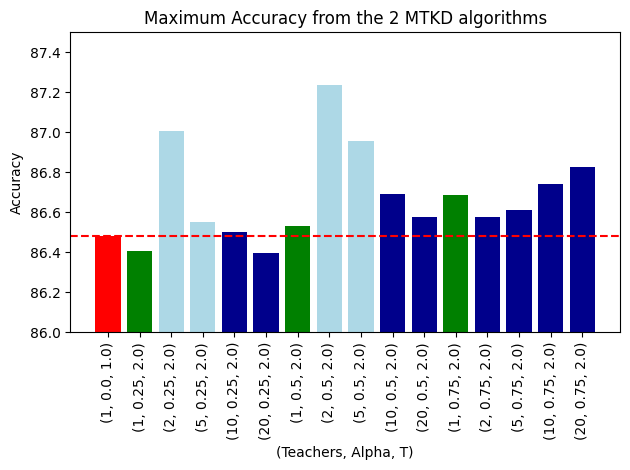

In [48]:
#@title Best students performances

max_counter = {}
for key in counter:
    if key in counter_2:
        max_counter[key] = max(counter[key], counter_2[key])
    else:
        max_counter[key] = counter[key]

for key in counter_2:
    if key not in max_counter:
        max_counter[key] = counter_2[key]

colors_max = ['darkblue' if max_counter[key] == counter.get(key, -float('inf')) else 'lightblue' for key in max_counter]
combined = list(max_counter.items()) + list(counter_T_2.items())
colors_combined = colors_max + ['red' if key == (1, 0.0, 1.0) else 'green' for key in counter_T_2]
sorted_combined = sorted(combined, key=lambda x: (x[0][1], x[0][0]))
keys_sorted, values_sorted = zip(*sorted_combined)
sorted_colors = [colors_combined[combined.index(item)] for item in sorted_combined]
labels_sorted = [str(key) for key in keys_sorted]

x_positions = np.arange(len(keys_sorted))

plt.bar(x_positions, values_sorted, color=sorted_colors)

red_value = next((value for key, value, color in combined_sorted if color == 'red'), None)

if red_value is not None:
    plt.axhline(y=red_value, color='red', linestyle='--', label=f'Red value: {red_value}')
plt.xticks(x_positions, labels_sorted, rotation=90)
plt.xlabel('(Teachers, Alpha, T)')
plt.ylabel('Accuracy')
plt.title('Maximum Accuracy from the 2 MTKD algorithms')
plt.ylim(86, 87.5)
plt.tight_layout()
plt.show()

The $\alpha$ that gave the best results in general is $\alpha=0.5$. The models that used this parameter held steadily above the baseline and, albeit briefly, also above the model trained with the same conditions but only one teacher.

By contrast, the number of teachers that I consider optimal is $5$. In fact with both algorithms the model trained with $5$ teachers performed competitively and above the baseline

### ***7. Self distillation***

As mentioned in section 2, there is a case where student and teacher coincide: Self Distillation.This type of distillation was introduced in the article *Be Your Own Teacher: Improve the Performance of Convolutional Neural Networks via Self Distillation* (Zhang, Song, Gao, Chen, Bao, Ma; 2019). This time, the teacher and student models coincide in a single model.In the implementation provided in this notebook, I have slightly modified the TeacherModel class, adding ‘outs’ after each layer so as to have intermediate ‘logits’ that contribute to the loss calculation in an equivalent manner. A possible further improvement could be to give a weight to the soft losses calculated from these intermediate features in the calculation of the total loss, making those at the end states contribute more, but the weight given would have to be calculated iteratively. In this notebook I will use the most trivial version, with all soft losses calculated at intermediate states having the same weight.

Furthermore, in the article cited above, the authors use a loss $L2$ from the hints, i.e. the most advanced features. In my implementation, I experimented with a ‘Self-Distillation in the middle’, i.e. applying only $D_{KL}$ to the intermediate logits without using the hints of the later features.

In [49]:
#@title 9. Self Distillation$^{11.3}$

url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/images_markdown/self_distillation.png'
Image(url=url, width = 900, height = 350)

I introduce the model described, with the same number of parameters as TeacherModel but with the intermediate representations made explicit.

In [50]:
class MLPWithSelfDistillation(nn.Module):
    def __init__(self, input_size = 28*28):
        super(MLPWithSelfDistillation, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

        self.classifier1 = nn.Linear(512, 10)
        self.classifier2 = nn.Linear(256, 10)
        self.classifier3 = nn.Linear(128, 10)
        self.classifier4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x1 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x1))
        x3 = F.relu(self.fc3(x2))
        x4 = F.relu(self.fc4(x3))
        out = self.fc5(x4)

        c1 = self.classifier1(x1)
        c2 = self.classifier2(x2)
        c3 = self.classifier3(x3)
        c4 = self.classifier4(x4)

        return out, c1, c2, c3, c4

In [51]:
sd_mlp = MLPWithSelfDistillation().to(device)
total_params = "{:,}".format(sum(p.numel() for p in sd_mlp.parameters()))
print(f"MLPWithSelfDistillation parameters: {total_params_deep}")
total_params_deep = "{:,}".format(sum(p.numel() for p in teacher.parameters()))
print(f"TeacherModel parameters: {total_params_deep}")

MLPWithSelfDistillation parameters: 575,050
TeacherModel parameters: 575,050


In [52]:
#@title Training and testing for Self-Distillation

def loss_fn_kd(outputs, labels, teacher_outputs, alpha=0.5, T=2):
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs / T, dim=1),
                             F.softmax(teacher_outputs / T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)
    return KD_loss

def train_self(model, alpha=0.5, epochs=10):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(1, epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            output, c1, c2, c3, c4 = model(data)

            loss1 = F.cross_entropy(c1, target)
            loss2 = F.cross_entropy(c2, target)
            loss3 = F.cross_entropy(c3, target)
            loss4 = F.cross_entropy(c4, target)
            loss_final = F.cross_entropy(output, target)

            kl_loss1 = loss_fn_kd(c1, target, output, alpha)
            kl_loss2 = loss_fn_kd(c2, target, output, alpha)
            kl_loss3 = loss_fn_kd(c3, target, output, alpha)
            kl_loss4 = loss_fn_kd(c4, target, output, alpha)

            loss = loss1 + loss2 + loss3 + loss4 + loss_final + kl_loss1 + kl_loss2 + kl_loss3 + kl_loss4

            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}/{epochs}, Loss: {loss / len(train_loader):.4f}")


    return model

def testSTKD(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _, _, _, _ = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

Now, as done previously, I try varying the value of $\alpha$ to see effects on the accuracy of the models and plot the results.

In [53]:
#@title Training MLPWithSelfDistillation with varying $\alpha$


teachersSTKD = []
teachers_STKD_05 = []
teachers_STKD_025 = []
teachers_STKD_075 = []
acc_teachers_STKD_05 = []
acc_teachers_STKD_025 = []
acc_teachers_STKD_075 = []
alphas = [0.25, 0.5, 0.75]
a_s = ['025', '05', '075']

prefix_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/STKD_'
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/STKD.json'

num_teachers = 20
for a in range(len(alphas)):
    for i in range(num_teachers):
        if not saved_results:
            if not trained_models:
                torch.manual_seed(i)
                teacher = MLPWithSelfDistillation().to(device)
                teacher = train(teacher, epochs=10)
                torch.save(teacher.state_dict(), f'teacher_{i}.pth')

                with zipfile.ZipFile(f'STKD_{a_s[a]}.zip', 'a') as zipf:
                    zipf.write(f'teacher_STKD_{a_s[a]}_{i}.pth')

                teacher_accuracy = testSTKD(teacher, test_loader)
            else:
                torch.manual_seed(i)
                teacher = load_model_from_github(MLPWithSelfDistillation, prefix_url+f'{a_s[a]}/teacher_STKD_{a_s[a]}_{i}.pth', device)
                teacher_accuracy = testSTKD(teacher, test_loader)

            if a_s[a] == '025':
                if import_models:
                    teachers_STKD_025.append(teacher)
                acc_teachers_STKD_025.append(teacher_accuracy)
            if a_s[a] == '05':
                if import_models:
                    teachers_STKD_05.append(teacher)
                acc_teachers_STKD_05.append(teacher_accuracy)
            else:
                if import_models:
                    teachers_STKD_075.append(teacher)
                acc_teachers_STKD_075.append(teacher_accuracy)

            if save_jsons:
                try:
                    with open(f'STKD.json', 'r') as json_file:
                        data = json.load(json_file)
                except FileNotFoundError:
                    data = {}

                if f'teacher_STKD_{a_s[a]}_{i}.pth' not in data:
                    data[f'teacher_STKD_{a_s[a]}_{i}.pth'] = teacher_accuracy

                    with open('STKD.json', 'w') as file:
                        json.dump(data, file, indent=4)

            if import_models:
                teachersSTKD.append(teacher)
        else:
            try:
                response = requests.get(json_url)
                STKD = response.json()
                print(f"Test accuracy: {STKD[f'teacher_STKD_{a_s[a]}_{i}.pth']}%")
            except requests.exceptions.RequestException as e:
                print(f"Error fetching JSON: {e}")
            if a_s[a] == '025':
                acc_teachers_STKD_025.append(STKD[f'teacher_STKD_{a_s[a]}_{i}.pth'])
            if a_s[a] == '05':
                acc_teachers_STKD_05.append(STKD[f'teacher_STKD_{a_s[a]}_{i}.pth'])
            else:
                acc_teachers_STKD_075.append(STKD[f'teacher_STKD_{a_s[a]}_{i}.pth'])

            if import_models:
                teacher = load_model_from_github(MLPWithSelfDistillation, prefix_url+f'{a_s[a]}/teacher_STKD_{a_s[a]}_{i}.pth', device)
                teachersSTKD.append(teacher)


Test accuracy: 88.61%
Test accuracy: 88.59%
Test accuracy: 88.66%
Test accuracy: 88.64%
Test accuracy: 88.48%
Test accuracy: 88.08%
Test accuracy: 88.63%
Test accuracy: 88.34%
Test accuracy: 88.53%
Test accuracy: 88.18%
Test accuracy: 89.03%
Test accuracy: 87.75%
Test accuracy: 88.55%
Test accuracy: 89.16%
Test accuracy: 87.38%
Test accuracy: 88.08%
Test accuracy: 88.55%
Test accuracy: 88.13%
Test accuracy: 88.22%
Test accuracy: 88.36%
Test accuracy: 88.68%
Test accuracy: 88.45%
Test accuracy: 88.64%
Test accuracy: 88.44%
Test accuracy: 88.61%
Test accuracy: 87.99%
Test accuracy: 88.22%
Test accuracy: 88.23%
Test accuracy: 88.38%
Test accuracy: 88.12%
Test accuracy: 88.96%
Test accuracy: 88.53%
Test accuracy: 88.77%
Test accuracy: 87.76%
Test accuracy: 88.29%
Test accuracy: 88.51%
Test accuracy: 88.21%
Test accuracy: 88.41%
Test accuracy: 88.13%
Test accuracy: 88.3%
Test accuracy: 88.17%
Test accuracy: 89.12%
Test accuracy: 88.4%
Test accuracy: 88.84%
Test accuracy: 88.42%
Test accurac

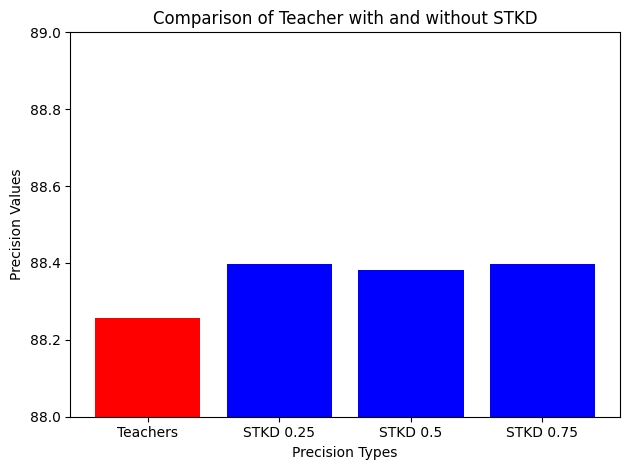

In [54]:
#@title Plotting results

if not saved_results:
    MTKD_first_teachers = {str(i):f_t[i] for i in range(num_teachers)}
teachers_precision = sum([MTKD_first_teachers[str(i)] for i in range(num_teachers)])/num_teachers
STKD025_precision = sum([acc_teachers_STKD_025[i] for i in range(num_teachers)])/num_teachers
STKD05_precision = sum([acc_teachers_STKD_05[i] for i in range(num_teachers)])/num_teachers
STKD075_precision = sum([acc_teachers_STKD_075[i] for i in range(num_teachers)])/num_teachers
precisions = [teachers_precision, STKD025_precision, STKD05_precision, STKD075_precision]
labels = ['Teachers', 'STKD 0.25', 'STKD 0.5', 'STKD 0.75']

colors = ['red'] + ['blue'] * 3

plt.bar(labels, precisions, color=colors)

plt.xlabel('Precision Types')
plt.ylabel('Precision Values')
plt.title('Comparison of Teacher with and without STKD')
plt.ylim(88, 89)
plt.tight_layout()
plt.show()

So the improvements were present for all $\alpha$ values despite the fact that the implementation was not the one from the article *Be your own Teacher* but a simplified version. This in my opinion shows the strength of the technique proposed by Zhang, Song, Gao, Chen, Bao, Ma, which, even if used in a simpler and less powerful version, still manages to improve already high accuracies.

However, I note that the improvements are minimal and I believe that by applying the ‘complete Self-Distillation’ and not the one 'in the middle' I would have had more important results.


### ***8. MTKD and model ensembles***.

I now begin a study in search of a hypothetical correlation between teacher ensemble accuracies and observed improvements in students, and if I notice correlations in practical examples.

First I define a function to get the accuracy of the model ensemble where the prediction is obtained of the average of all logits (MTKD with Prediction averaging)

In [55]:
#@title Accuracy model ensemble

def combine_teacher_predictions(teacher_models, STKD = False, test_loader = test_loader, temperature=2.0):

    correct_predictions = 0
    total_samples = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        logits_list = []
        for teacher in teacher_models:
            teacher.eval()
            with torch.no_grad():
                if STKD: logits, _, _, _, _ = teacher(inputs)
                else: logits = teacher(inputs)

                logits = logits / temperature
                logits_list.append(logits)

        stacked_logits = torch.stack(logits_list)

        combined_logits = torch.mean(stacked_logits, dim=0)

        predictions = torch.argmax(combined_logits, dim=1)

        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy*100

From this point on, if import_models was set False then it's mandatory to set saved_results=True for the cells marked with * to execute

In [56]:
#@title MLP ensemble accuracy *

json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/combined_teacher_predictions.json'
if not saved_results:
    try:
        with open('combined_teacher_predictions.json', 'r') as json_file:
            CT = json.load(json_file)
    except FileNotFoundError:
        CT = {}

    combined_teachers = combine_teacher_predictions(teachersMTKD)
    combined_teachers025 = combine_teacher_predictions(teachers_STKD_025, STKD=True)
    combined_teachers05 = combine_teacher_predictions(teachers_STKD_05, STKD=True)
    combined_teachers075 = combine_teacher_predictions(teachers_STKD_075, STKD=True)

    if 'combined_teachers' not in CT:
        CT['combined_teachers'] = combined_teachers
    if 'combined_teachers025' not in CT:
        CT['combined_teachers025'] = combined_teachers025
    if 'combined_teachers05' not in CT:
        CT['combined_teachers05'] = combined_teachers05
    if 'combined_teachers075' not in CT:
        CT['combined_teachers075'] = combined_teachers075

    with open('combined_teacher_predictions.json', 'w') as file:
        json.dump(CT, file, indent=4)

else:
        try:
            response = requests.get(json_url)
            CT = response.json()
            print(f"TeacherModels: {CT['combined_teachers']}%")
            print(f"STKD025 teachers: {CT['combined_teachers025']}%")
            print(f"STKD05 teachers: {CT['combined_teachers05']}%")
            print(f"STKD075 teachers: {CT['combined_teachers075']}%")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching JSON: {e}")


TeacherModels: 89.75%
STKD025 teachers: 89.87%
STKD05 teachers: 90.0%
STKD075 teachers: 89.94%


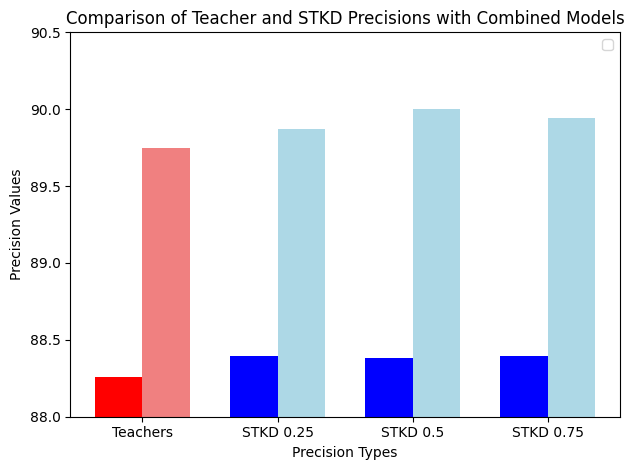

In [57]:
#@title Comparison with models' average accuracy *

precisions = [teachers_precision, STKD025_precision, STKD05_precision, STKD075_precision]
combined_precisions = [CT['combined_teachers'], CT['combined_teachers025'], CT['combined_teachers05'], CT['combined_teachers075']]
labels = ['Teachers', 'STKD 0.25', 'STKD 0.5', 'STKD 0.75']

colors = ['red'] + ['blue'] * 3
combined_colors = ['lightcoral'] + ['lightblue'] * 3

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, precisions, width, color=colors)
bars2 = ax.bar(x + width/2, combined_precisions, width, color=combined_colors)

ax.set_xlabel('Precision Types')
ax.set_ylabel('Precision Values')
ax.set_title('Comparison of Teacher and STKD Precisions with Combined Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.set_ylim(88, 90.5)

ax.legend()

plt.tight_layout()
plt.show()


It is noticeable that the accuracy of the model ensemble is stably above the average accuracy of the same model, because the few different predictions of the individual models are corrected by the majority of models that perform them correctly. At the same time, I notice that the difference between models trained with Self-Distillation and those without remains minimal even in this case. I intuit that students trained using these models as teachers may have imperceptible improvements.

I try the training anyway

In [58]:
#@title Training models via MTKD with 2, 5, 10, 20 teachers trained with Self-Distillation and different $\alpha$ values
joint_students = []
num_teachers = [2, 5, 10, 20]
alphas = [0.25, 0.5, 0.75]
a_s = ['025', '05', '075']
num_iterations = 5
for_graph3 = []
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/MTKD_STKD_AVG.json'
for num in num_teachers:
    for i in range(num_iterations):
        model_url = f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/Final_2_students_05/Final_2_student05_{num}_{i}.pth'
        if not saved_results:
            if not trained_models:
                torch.manual_seed(i)

                student_model_distillated = StudentModel().to(device)
                student_model_distillated = train_student_model_multi_teacher(teachers_STKD_05[:num], student_model_distillated, epochs=10, alpha=alphas[a], T=2.0)
                student_distillated_accuracy = test_model(student_model_distillated, test_loader)
                torch.save(student_model_distillated.state_dict(), f'Final_2_student05_{num}_{i}.pth')
                with zipfile.ZipFile('Final_2_students_05.zip', 'a') as zipf:
                    zipf.write(f'Final_2_student05_{num}_{i}.pth')
            else:
                torch.manual_seed(i)
                student_model_distillated = load_model_from_github(StudentModel, model_url, device)
                student_distillated_accuracy = test_model(student_model_distillated, test_loader)
            for_graph3.append([student_distillated_accuracy, num, 0.5, 2.0])

            if save_jsons:
                try:
                    with open('MTKD_STKD_AVG.json', 'r') as json_file:
                        data = json.load(json_file)
                except FileNotFoundError:
                    data = {}

                key = f'Final_2_student05_{num}_{i}.pth'
                if key not in data:
                    data[key] = [student_distillated_accuracy, num, 0.5, 2.0]

                    with open('MTKD_STKD_AVG.json', 'w') as file:
                        json.dump(data, file, indent=4)

            if import_models:
                joint_students.append(student_model_distillated)
        else:
            try:
                response = requests.get(json_url)
                MTKD_STKD_AVG = response.json()
                print(f"Test accuracy: {MTKD_STKD_AVG[f'Final_2_student05_{num}_{i}.pth'][0]}%")
            except requests.exceptions.RequestException as e:
                print(f"Error fetching JSON: {e}")
            for_graph3.append(MTKD_STKD_AVG[f'Final_2_student05_{num}_{i}.pth'])
            if import_models:
                    student = load_model_from_github(StudentModel, model_url, device)
                    teachersMTKD.append(teacher)

Test accuracy: 87.07%
Test accuracy: 86.82%
Test accuracy: 87.17%
Test accuracy: 86.01%
Test accuracy: 85.74%
Test accuracy: 87.09%
Test accuracy: 86.86%
Test accuracy: 86.91%
Test accuracy: 86.09%
Test accuracy: 85.51%
Test accuracy: 87.25%
Test accuracy: 86.76%
Test accuracy: 86.94%
Test accuracy: 86.33%
Test accuracy: 85.75%
Test accuracy: 87.05%
Test accuracy: 86.9%
Test accuracy: 86.8%
Test accuracy: 86.21%
Test accuracy: 85.42%


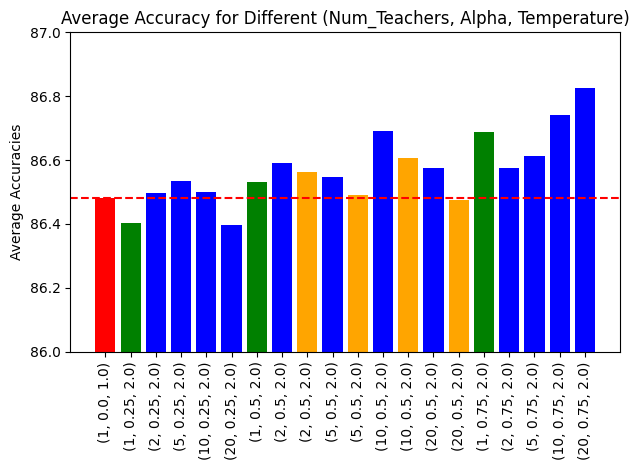

In [59]:
#@title Average accuracy graph for student models with Self-Distillation trained teachers compared to previous data
counter_3 = {}

for el in for_graph3:
    add = el[0]/num_iterations
    if (el[1], el[2], el[3]) not in counter_3:
        counter_3[(el[1], el[2], el[3])] = add
    else:
        counter_3[(el[1], el[2], el[3])] += add

keys1 = list(counter.keys())
values1 = list(counter.values())
keys2 = list(counter_T_2.keys())
values2 = list(counter_T_2.values())
keys3 = list(counter_3.keys())
values3 = list(counter_3.values())
combined = (
    list(zip(keys1, values1, ['blue'] * len(keys1))) +
    list(zip(keys2, values2, ['red' if key == (1, 0.0, 1.0) else 'green' for key in keys2])) +
    list(zip(keys3, values3, ['orange'] * len(keys3)))
)
combined_sorted = sorted(combined, key=lambda x: (x[0][1], x[0][0]))

keys_sorted, values_sorted, colors_sorted = zip(*combined_sorted)

labels_sorted = [str(key) for key in keys_sorted]

x_positions = np.arange(len(keys_sorted))

plt.bar(x_positions, values_sorted, color=colors_sorted)

red_value = next((value for key, value, color in combined_sorted if color == 'red'), None)

if red_value is not None:
    plt.axhline(y=red_value, color='red', linestyle='--', label=f'Red value: {red_value}')

plt.xticks(x_positions, labels_sorted, rotation=90)
plt.ylabel('Average Accuracies')
plt.title('Average Accuracy for Different (Num_Teachers, Alpha, Temperature)')

plt.ylim(86, 87)

plt.tight_layout()
plt.show()

Using the MTKD graph with Prediction averaging, I add in orange students with self-distillated teachers. Overall accuracy is deteriorating. Probably the final logits of these models are not as informative. In fact I think that the applied loss may have benefited the individual models but have created some final logits of worse quality with many similar values among them that do not help the student. This is because the "Self-Distillation in the middle", which gave equal weight to intermediate logits, despite creating more precise final logits, perhaps made these last go out of scale and did not guarantee an extreme conviction in the prediction of the class.

If the graph does not show correctly I recommend to restart the runtime and run everything with the settings given in the introduction (to ensure a fast execution) Since it refers to old data that may have been lost running the same cell multiple times.


### ***9. Different teachers***

I try to improve students' performance by providing them with a wide range of information from models of different types than their own. In addition to the MLP I add CNN and ShallowDenseNet

In [60]:
class CNNTeacherModel(nn.Module):
    def __init__(self, input_size=28*28):
        super(CNNTeacherModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ShallowDenseNet(nn.Module):
    def __init__(self, input_size = 28*28, num_channels = 1):
        super(ShallowDenseNet, self).__init__()
        self.input_size = input_size
        self.conv1 = nn.Conv2d(num_channels, 8, kernel_size=3, padding=1)
        self.denseblock = nn.Sequential(
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 8, kernel_size=3, padding=1)
        )
        self.fc = nn.Linear(8 * input_size, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.denseblock(x) + x
        x = x.view(-1, 8 * self.input_size)
        x = self.fc(x)
        return x

I now train teachers of different types (still on fashionMNIST)

In [61]:
#@title Training the new teachers

num_teachers = [2,5,10,20]
final_teachers = []

num_iterations = 5
prefix_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/Last_Teachers'
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/Last_Teachers.json'

for i in range(num_iterations):
    if not saved_results:
        if not trained_models:
            torch.manual_seed(i)
            cnn = CNNTeacherModel()
            train(cnn, 10)
            torch.save(cnn.state_dict(), f'CNN_teacher_{i}.pth')
            with zipfile.ZipFile('Last_Teachers.zip', 'a') as zipf: zipf.write(f'CNN_teacher_{i}.pth')
            torch.manual_seed(i)
            shallowdensenet = ShallowDenseNet()
            train(shallowdensenet, 10)
            torch.save(shallowdensenet.state_dict(), f'shallowdensenet_teacher_{i}.pth')
            with zipfile.ZipFile('Last_Teachers.zip', 'a') as zipf: zipf.write(f'shallowdensenet_teacher_{i}.pth')

        else:
            torch.manual_seed(i)
            cnn = load_model_from_github(CNNTeacherModel, prefix_url+f'/CNN_teacher_{i}.pth', device)
            cnn_acc = test_model(cnn, test_loader)

            sdnt = load_model_from_github(ShallowDenseNet, prefix_url+f'/shallowdensenet_teacher_{i}.pth', device)
            sdnt_acc = test_model(sdnt, test_loader)

            mlp = load_model_from_github(TeacherModel, f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/MTKD/teacher_{i}.pth', device)
            mlp_acc = test_model(mlp, test_loader)

            if import_models:
                final_teachers.append(cnn)
                final_teachers.append(sdnt)
                final_teachers.append(mlp)

            if save_jsons:
                try:
                    with open(f'Last_Teachers.json', 'r') as json_file:
                        Last_Teachers = json.load(json_file)
                except FileNotFoundError:
                    Last_Teachers = {}

                if f'CNN_teacher_{i}.pth' not in Last_Teachers:
                    Last_Teachers[f'CNN_teacher_{i}.pth'] = cnn_acc

                    with open('Last_Teachers.json', 'w') as file:
                        json.dump(Last_Teachers, file, indent=4)

                if f'shallowdensenet_teacher_{i}.pth' not in Last_Teachers:
                    Last_Teachers[f'shallowdensenet_teacher_{i}.pth'] = sdnt_acc

                    with open('Last_Teachers.json', 'w') as file:
                        json.dump(Last_Teachers, file, indent=4)

                if f'teacher_{i}.pth' not in Last_Teachers:
                    Last_Teachers[f'teacher_{i}.pth'] = mlp_acc

                    with open('Last_Teachers.json', 'w') as file:
                        json.dump(Last_Teachers, file, indent=4)
    else:
        try:
            response = requests.get(json_url)
            Last_Teachers = response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching JSON: {e}")
        print(f"CNN test accuracy: {Last_Teachers[f'CNN_teacher_{i}.pth']}%")
        print(f"ShallowDenseNet test accuracy: {Last_Teachers[f'shallowdensenet_teacher_{i}.pth']}%")
        print(f"MLP test accuracy: {Last_Teachers[f'teacher_{i}.pth']}%")

        if import_models:
            cnn = load_model_from_github(CNNTeacherModel, prefix_url+f'/CNN_teacher_{i}.pth', device)
            sdnt = load_model_from_github(ShallowDenseNet, prefix_url+f'/shallowdensenet_teacher_{i}.pth', device)
            mlp = load_model_from_github(TeacherModel, f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/MTKD/teacher_{i}.pth', device)

            final_teachers += [cnn, sdnt, mlp]


CNN test accuracy: 91.63%
ShallowDenseNet test accuracy: 89.44%
MLP test accuracy: 88.27%
CNN test accuracy: 92.02%
ShallowDenseNet test accuracy: 89.14%
MLP test accuracy: 88.23%
CNN test accuracy: 92.02%
ShallowDenseNet test accuracy: 88.89%
MLP test accuracy: 87.95%
CNN test accuracy: 91.93%
ShallowDenseNet test accuracy: 89.51%
MLP test accuracy: 88.32%
CNN test accuracy: 91.87%
ShallowDenseNet test accuracy: 89.32%
MLP test accuracy: 88.13%


As previously done, I check the accuracy of the "ensemble model" where logits are the average of the teachers' logits

In [62]:
#@title Combined accuracies *
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/combined_teacher_predictions.json'
if not saved_results:
    try:
        with open('combined_teacher_predictions.json', 'r') as json_file:
            Last_Teachers = json.load(json_file)
    except FileNotFoundError:
        Last_Teachers = {}

    combined_final_teachers = combine_teacher_predictions(final_teachers)
    print(f'Test accuracy: {combined_final_teachers}')
    if save_jsons:
        if 'combined_final_teachers' not in Last_Teachers:
            Last_Teachers['combined_final_teachers'] = combined_final_teachers
            with open('combined_teacher_predictions.json', 'w') as file:
                json.dump(Last_Teachers, file, indent=4)
else:
    try:
        response = requests.get(json_url)
        CT = response.json()
        print(f"Test accuracy: {CT['combined_final_teachers']}%")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching JSON: {e}")


Test accuracy: 93.03%


Now I check the differences of the ensemble model with all MLP and mixed one. I do this by taking the image formed by the average of the images classified incorrectly on the test set.

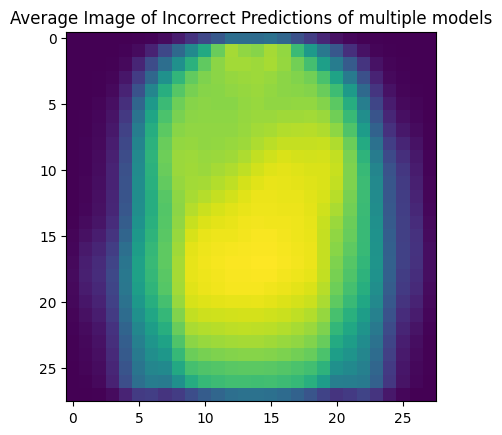

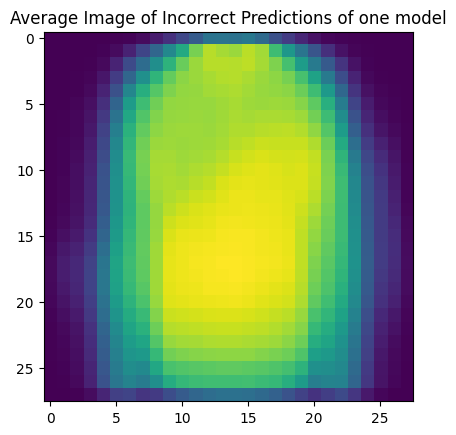

In [63]:
#@title MLPs *

def test_and_collect_incorrect(model, loader):
    model.eval()
    incorrect_images = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            incorrect_mask = ~pred.eq(target.view_as(pred)).squeeze()
            incorrect_images.extend(data[incorrect_mask].cpu().numpy())
    return incorrect_images

all_incorrect_images = []

if not saved_results:
    for model in teachersMTKD:
        incorrect_images = test_and_collect_incorrect(model, train_loader)
        all_incorrect_images.extend(incorrect_images)

    first_incorrect_images = test_and_collect_incorrect(teachersMTKD[0], train_loader)
    avg_image = np.mean(np.stack(all_incorrect_images), axis=0)
    first_avg_image = np.mean(np.stack(first_incorrect_images), axis=0)
    np.save('average_incorrect_image_same_models.npy', avg_image)
    np.save('average_incorrect_image_1_MLP.npy', first_avg_image)


else:
    url1 = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/files_npy_images/average_incorrect_image_same_models.npy"
    url2 = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/files_npy_images/average_incorrect_image_1_MLP.npy"
    response1 = requests.get(url1)
    response2 = requests.get(url2)
    file_stream1 = io.BytesIO(response1.content)
    file_stream2 = io.BytesIO(response2.content)

    avg_image = np.load(file_stream1)
    first_avg_image = np.load(file_stream2)

plt.imshow(np.transpose(avg_image, (1, 2, 0)))
plt.title("Average Image of Incorrect Predictions of multiple models")
plt.show()

plt.imshow(np.transpose(first_avg_image, (1, 2, 0)))
plt.title("Average Image of Incorrect Predictions of one model")
plt.show()


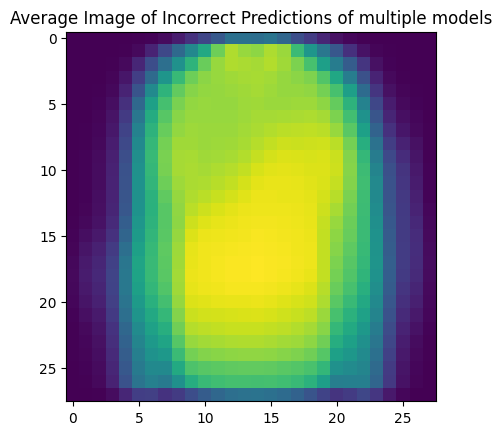

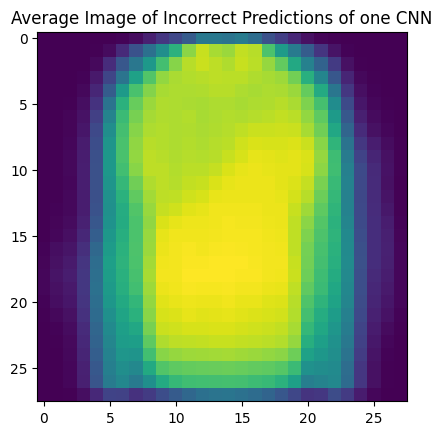

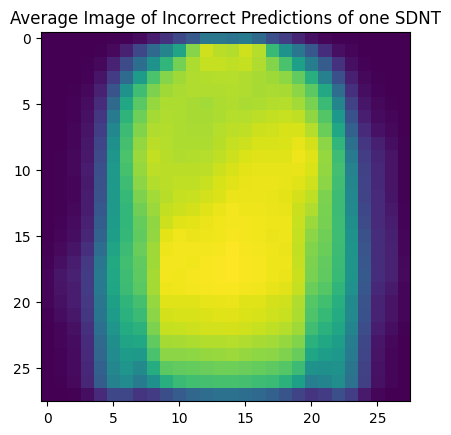

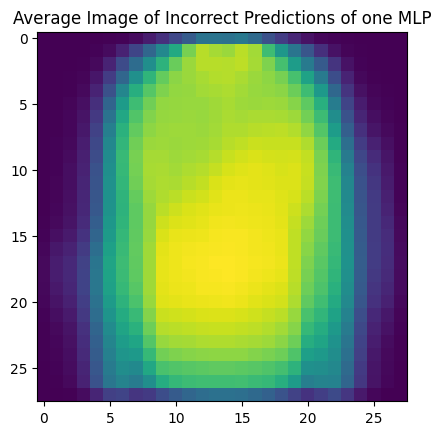

In [64]:
#@title Different models ensemble *


def test_and_collect_incorrect(model, loader):
    model.eval()
    incorrect_images = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            incorrect_mask = ~pred.eq(target.view_as(pred)).squeeze()
            incorrect_images.extend(data[incorrect_mask].cpu().numpy())
    return incorrect_images

all_incorrect_images = []

if not saved_results:
    for model in final_teachers:
        incorrect_images = test_and_collect_incorrect(model, train_loader)
        all_incorrect_images.extend(incorrect_images)

    first_incorrect_images = test_and_collect_incorrect(final_teachers[0], train_loader)
    second_incorrect_images = test_and_collect_incorrect(final_teachers[1], train_loader)
    third_incorrect_images = test_and_collect_incorrect(final_teachers[2], train_loader)

    avg_image = np.mean(np.stack(all_incorrect_images), axis=0)

    first_avg_image = np.mean(np.stack(first_incorrect_images), axis=0)
    second_avg_image = np.mean(np.stack(second_incorrect_images), axis=0)
    third_avg_image = np.mean(np.stack(third_incorrect_images), axis=0)

    np.save('average_incorrect_image_different_models.npy', avg_image)
    np.save('average_incorrect_image_2_CNN.npy', first_avg_image)
    np.save('average_incorrect_image_2_SDNT.npy', avg_image)
    np.save('average_incorrect_image_2_MLP.npy', first_avg_image)

else:
    url1 = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/files_npy_images/average_incorrect_image_different_models.npy"
    url2 = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/files_npy_images/average_incorrect_image_2_CNN.npy"
    url3 = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/files_npy_images/average_incorrect_image_2_SDNT.npy"
    url4 = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/files_npy_images/average_incorrect_image_2_MLP.npy"

    response1 = requests.get(url1)
    response2 = requests.get(url2)
    response3 = requests.get(url3)
    response4 = requests.get(url4)

    file_stream1 = io.BytesIO(response1.content)
    file_stream2 = io.BytesIO(response2.content)
    file_stream3 = io.BytesIO(response3.content)
    file_stream4 = io.BytesIO(response4.content)

    avg_image = np.load(file_stream1)
    first_avg_image = np.load(file_stream2)
    second_avg_image = np.load(file_stream3)
    third_avg_image = np.load(file_stream4)

plt.imshow(np.transpose(avg_image, (1, 2, 0)))
plt.title("Average Image of Incorrect Predictions of multiple models")
plt.show()

plt.imshow(np.transpose(first_avg_image, (1, 2, 0)))
plt.title("Average Image of Incorrect Predictions of one CNN")
plt.show()

plt.imshow(np.transpose(second_avg_image, (1, 2, 0)))
plt.title("Average Image of Incorrect Predictions of one SDNT")
plt.show()

plt.imshow(np.transpose(third_avg_image, (1, 2, 0)))
plt.title("Average Image of Incorrect Predictions of one MLP")
plt.show()

As it can be seen, in both cases the ensemble has some areas improved, like the upper area. The image of mixed ensemble errors does not seem (at least to the eye) an improvement compared to that of MLPs. But this is definitely a human limit: that "ensemble model" has accuracy above $93$% versus the MLPs around $90$%.

I am looking for an effect of this theoretical improvement of teachers on students, training students this time with $3$, $9$ and $15$ teachers taken from this model. These are numbers chosen to ensure that the CNN, Shallowdensenet and MLP numbers are always the same among teachers of different models.

In [65]:
#@title Training StudentModels with different teachers

num_teachers = [3, 9, 15]
store_finale_MTKD_students = []
num_iterations = 5
for_graph4 = []
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/MTKD_finale.json'
for num in num_teachers:
    for i in range(num_iterations):
        model_url = f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/MTKD_finale/MTKD_finale_student05_{num}_{i}.pth'
        if not saved_results:
            if not trained_models:
                torch.manual_seed(i)
                student_model_distillated = StudentModel().to(device)
                student_model_distillated = train_student_model_multi_teacher(final_teachers[:num], student_model_distillated, epochs=10, alpha=0.5, T=2.0)
                student_distillated_accuracy = test_model(student, test_loader)
                torch.save(student.state_dict(), f'MTKD_finale_student05_{num}_{i}.pth')
                with zipfile.ZipFile('MTKD_finale.zip', 'a') as zipf:
                    zipf.write(f'MTKD_finale_student05_{num}_{i}.pth')
            else:
                torch.manual_seed(i)
                student_model_distillated = load_model_from_github(StudentModel, model_url, device)
                student_distillated_accuracy = test_model(student_model_distillated, test_loader)
            for_graph4.append([student_distillated_accuracy, num, 0.5, 2.0])

            if import_models:
                store_finale_MTKD_students.append(student_model_distillated)

            if save_jsons:
                try:
                    with open('MTKD_finale.json', 'r') as json_file:
                        data = json.load(json_file)
                except FileNotFoundError:
                    data = {}

                key = f'{num}_{i}'
                if key not in data:
                    data[key] = [student_distillated_accuracy, num, 0.5, 2.0]

                    with open('MTKD_finale.json', 'w') as file:
                        json.dump(data, file, indent=4)
        else:
            try:
                response = requests.get(json_url)
                MTKD_finale = response.json()
                print(f"Test accuracy: {MTKD_finale[f'{num}_{i}'][0]}%")
            except requests.exceptions.RequestException as e:
                print(f"Error fetching JSON: {e}")

            for_graph4.append(MTKD_finale[f'{num}_{i}'])

            if import_models:
                    teacher = load_model_from_github(StudentModel, model_url, device)
                    teachersMTKD.append(teacher)

Test accuracy: 86.7%
Test accuracy: 86.66%
Test accuracy: 87.13%
Test accuracy: 86.04%
Test accuracy: 85.83%
Test accuracy: 86.7%
Test accuracy: 86.66%
Test accuracy: 87.13%
Test accuracy: 86.04%
Test accuracy: 85.83%
Test accuracy: 86.7%
Test accuracy: 86.66%
Test accuracy: 87.13%
Test accuracy: 86.04%
Test accuracy: 85.83%


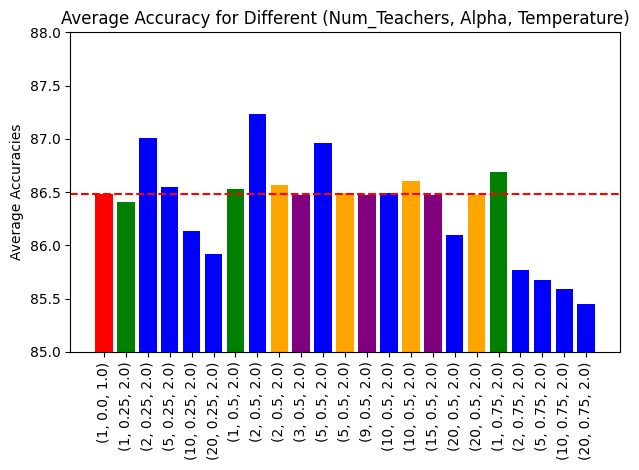

In [66]:
#@title Plotting results

counter_4 = {}

for el in for_graph4:
    add = el[0] / num_iterations
    if (el[1], el[2], el[3]) not in counter_4:
        counter_4[(el[1], el[2], el[3])] = add
    else:
        counter_4[(el[1], el[2], el[3])] += add

keys1 = list(counter_2.keys())
values1 = list(counter_2.values())
keys2 = list(counter_T_2.keys())
values2 = list(counter_T_2.values())
keys3 = list(counter_3.keys())
values3 = list(counter_3.values())
keys4 = list(counter_4.keys())
values4 = list(counter_4.values())

combined = (
    list(zip(keys1, values1, ['blue'] * len(keys1))) +
    list(zip(keys2, values2, ['red' if key == (1, 0.0, 1.0) else 'green' for key in keys2])) +
    list(zip(keys3, values3, ['orange'] * len(keys3))) +
    list(zip(keys4, values4, ['purple'] * len(keys4)))
)

combined_sorted = sorted(combined, key=lambda x: (x[0][1], x[0][0]))
keys_sorted, values_sorted, colors_sorted = zip(*combined_sorted)
labels_sorted = [str(key) for key in keys_sorted]
x_positions = np.arange(len(keys_sorted))
plt.bar(x_positions, values_sorted, color=colors_sorted)

red_value = next((value for key, value, color in combined_sorted if color == 'red'), None)

if red_value is not None:
    plt.axhline(y=red_value, color='red', linestyle='--', label=f'Red value: {red_value}')

plt.xticks(x_positions, labels_sorted, rotation=90)
plt.ylabel('Average Accuracies')
plt.title('Average Accuracy for Different (Num_Teachers, Alpha, Temperature)')
plt.ylim(85, 88)
plt.tight_layout()
plt.show()

This also didn’t improve the results... Maybe it’s the dataset? Maybe it’s too simple and the StudentModels are already too precise? I try it all over again with CIFAR-10.

### ***10. CFIAR-10***

All the processes I will carry out have been explained in previous sections, in this section I will limit to perform them to observe the results. MLP networks will remain unchanged by changing only the size of the input in 32x32x3 given the 3 channels of these images (they are color images). Given the time taken for images with this amount of information, I will run 3 iterations instead of 5 to get the accuracy

Files already downloaded and verified
Files already downloaded and verified


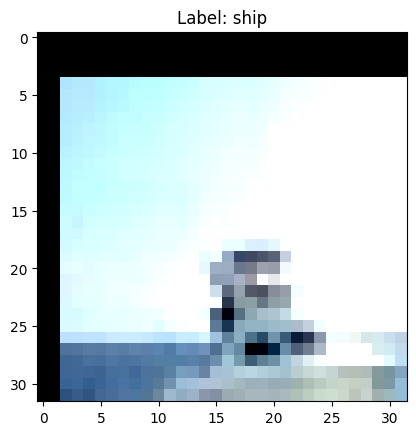

In [67]:
#@title import dataset

torch.manual_seed(0)

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])


train_setCIFAR = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)


test_setCIFAR = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)


train_loaderCIFAR = DataLoader(
    train_setCIFAR,
    batch_size=64,
    shuffle=True,
    num_workers=2
)


test_loaderCIFAR = DataLoader(
    test_setCIFAR,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

classes = train_setCIFAR.classes
image, label = train_setCIFAR[100]
image = image / 2 + 0.5
np_image = image.numpy()
np_image = np.transpose(np_image, (1, 2, 0))

plt.imshow(np_image)
plt.title(f'Label: {classes[label]}')
plt.show()


In [68]:
#@title Training 20 TeacherModels
teacher_modelsCIFAR = []

num_teachers = 20
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/CIFAR_teachers.json'
for i in range(num_teachers):
    model_url = f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/CIFAR_teachers/MLP_CIFAR_teacher_{i}.pth'#corretto
    if not saved_results:
        if not trained_models:
            torch.manual_seed(i)
            teacher = TeacherModel(32*32*3).to(device)
            teacher = train(teacher, epochs=10, train_loader = train_loaderCIFAR)

            torch.save(teacher.state_dict(), f'MLP_CIFAR_teacher_{i}.pth')

            with zipfile.ZipFile('CIFAR_teachers.zip', 'a') as zipf:
                zipf.write(f'MLP_CIFAR_teacher_{i}.pth')

            teacher_accuracy = test_model(teacher, test_loaderCIFAR)
        else:
            torch.manual_seed(i)
            teacher = load_model_from_github(TeacherModel, model_url, device, 32*32*3)
            teacher_accuracy = test_model(teacher, test_loaderCIFAR)

        if save_jsons:
            try:
                with open('CIFAR_teachers.json', 'r') as json_file:
                    data = json.load(json_file)
            except FileNotFoundError:
                data = {}

            if f'MLP_CIFAR_teacher_{i}.pth' not in data:
                data[f'MLP_CIFAR_teacher_{i}.pth'] = teacher_accuracy

                with open('CIFAR_teachers.json', 'w') as file:
                    json.dump(data, file, indent=4)
        if import_models:
            teacher_modelsCIFAR.append(teacher)
    else:
        try:
            response = requests.get(json_url)
            cifar_teachers = response.json()
            print(f"Test accuracy: {cifar_teachers[f'MLP_CIFAR_teacher_{i}.pth']}%")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching JSON: {e}")

        if import_models:
                teacher = load_model_from_github(TeacherModel, model_url, device, 32*32*3)
                teacher_modelsCIFAR.append(teacher)

Test accuracy: 46.17%
Test accuracy: 48.7%
Test accuracy: 47.7%
Test accuracy: 48.58%
Test accuracy: 47.65%
Test accuracy: 48.25%
Test accuracy: 47.88%
Test accuracy: 46.1%
Test accuracy: 47.58%
Test accuracy: 48.52%
Test accuracy: 47.71%
Test accuracy: 48.81%
Test accuracy: 47.33%
Test accuracy: 46.92%
Test accuracy: 47.35%
Test accuracy: 46.93%
Test accuracy: 48.11%
Test accuracy: 46.56%
Test accuracy: 46.71%
Test accuracy: 46.8%


In [69]:
#@title Defining the other NNs$^{11.4}$

class DeepCNN(nn.Module):
    def __init__(self, input_size = 32*32):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class ShallowDenseNet2(nn.Module):
    def __init__(self, input_size = 32*32, num_channels = 3):
        super(ShallowDenseNet2, self).__init__()
        self.input_size = input_size
        self.conv1 = nn.Conv2d(num_channels, 8, kernel_size=3, padding=1)
        self.denseblock = nn.Sequential(
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 8, kernel_size=3, padding=1)
        )
        self.fc = nn.Linear(8 * input_size, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.denseblock(x) + x
        x = x.view(-1, 8 * self.input_size)
        x = self.fc(x)
        return x

In [70]:
#@title Training the other NNs

teacher_modelsCIFAR_different = []
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/CIFAR_teachers.json'
prefix_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/CIFAR_teachers'
for i in range(5):
    if not saved_results:
        if not trained_models:
            torch.manual_seed(i)
            cnn = DeepCNN().to(device)
            train(cnn, 10, train_loaderCIFAR)
            torch.save(cnn.state_dict(), f'CNN_CIFAR_teacher_{i}.pth')
            with zipfile.ZipFile('CIFAR_teachers.zip', 'a') as zipf: zipf.write(f'CNN_CIFAR_teacher_{i}.pth')
            torch.manual_seed(i)
            shallowdensenet = ShallowDenseNet2().to(device)
            train(shallowdensenet, 10, train_loaderCIFAR)
            torch.save(shallowdensenet.state_dict(), f'SDNT_CIFAR_teacher_{i}.pth')
            with zipfile.ZipFile('CIFAR_teachers.zip', 'a') as zipf: zipf.write(f'SDNT_CIFAR_teacher_{i}.pth')

        else:
            torch.manual_seed(i)

            cnn = load_model_from_github(DeepCNN, prefix_url+f'/CNN_CIFAR_teacher_{i}.pth', device)
            cnn_acc = test_model(cnn, test_loaderCIFAR)

            sdnt = load_model_from_github(ShallowDenseNet2, prefix_url+f'/SDNT_CIFAR_teacher_{i}.pth', device, 32*32)
            sdnt_acc = test_model(sdnt, test_loaderCIFAR)

            mlp = load_model_from_github(TeacherModel, prefix_url+f'/MLP_CIFAR_teacher_{i}.pth', device, 32*32*3)
            mlp_acc = test_model(mlp, test_loaderCIFAR)

            teacher_modelsCIFAR_different.append(cnn)
            teacher_modelsCIFAR_different.append(sdnt)
            teacher_modelsCIFAR_different.append(mlp)

            if save_jsons:
                try:
                    with open(f'CIFAR_teachers.json', 'r') as json_file:
                        CIFAR_teachers = json.load(json_file)
                except FileNotFoundError:
                    CIFAR_teachers = {}

                if f'CNN_teacher_{i}.pth' not in CIFAR_teachers:
                    CIFAR_teachers[f'CNN_CIFAR_teacher_{i}.pth'] = cnn_acc

                if f'SDNT_teacher_{i}.pth' not in CIFAR_teachers:
                    CIFAR_teachers[f'SDNT_CIFAR_teacher_{i}.pth'] = sdnt_acc

                if f'MLP_teacher_{i}.pth' not in CIFAR_teachers:
                    CIFAR_teachers[f'MLP_CIFAR_teacher_{i}.pth'] = mlp_acc

                with open('CIFAR_teachers.json', 'w') as file:
                    json.dump(CIFAR_teachers, file, indent=4)
    else:
        try:
            response = requests.get(json_url)
            CIFAR_teachers = response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching JSON: {e}")
        print(f"CNN test accuracy: {CIFAR_teachers[f'CNN_CIFAR_teacher_{i}.pth']}%")
        print(f"ShallowDenseNet test accuracy: {CIFAR_teachers[f'SDNT_CIFAR_teacher_{i}.pth']}%")
        print(f"MLP test accuracy: {CIFAR_teachers[f'MLP_CIFAR_teacher_{i}.pth']}%")

        if import_models:
            cnn = load_model_from_github(DeepCNN, prefix_url+f'/CNN_CIFAR_teacher_{i}.pth', device)
            sdnt = load_model_from_github(ShallowDenseNet2, prefix_url+f'/SDNT_CIFAR_teacher_{i}.pth', device, 32*32)
            mlp = load_model_from_github(TeacherModel, prefix_url+f'/MLP_CIFAR_teacher_{i}.pth', device, 32*32*3)

            teacher_modelsCIFAR_different += [cnn, sdnt, mlp]

CNN test accuracy: 76.3%
ShallowDenseNet test accuracy: 62.52%
MLP test accuracy: 46.17%
CNN test accuracy: 79.9%
ShallowDenseNet test accuracy: 63.08%
MLP test accuracy: 48.7%
CNN test accuracy: 79.27%
ShallowDenseNet test accuracy: 63.07%
MLP test accuracy: 47.7%
CNN test accuracy: 77.79%
ShallowDenseNet test accuracy: 61.78%
MLP test accuracy: 48.58%
CNN test accuracy: 78.28%
ShallowDenseNet test accuracy: 62.33%
MLP test accuracy: 47.65%


I define a dictionary to store the results of the various tests in this section

In [71]:
plot = {'baseline': [],
 '1 MLP': [],
 '2 MLP': [],
 '5 MLP': [],
 '10 MLP': [],
 '20 MLP': [],
 '1 CNN05': [],
 '1 CNN075': [],
 '3 mixed models': [],
 '9 mixed models': [],
 '15 mixed models': []}

In [72]:
#@title StudentModel baseline
student_models_CIFAR_1 = []

json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/baseline_CIFAR.json'

for i in range(3):
    model_url = f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/CIFAR_baseline/smaller_model_{i}_CIFAR.pth'
    if not saved_results:
        if not trained_models:
            torch.manual_seed(i)
            smaller_model = StudentModel(input_size = 32*32*3).to(device)
            smaller_model = train(smaller_model, 10, train_loaderCIFAR)
            smaller_accuracy = test_model(smaller_model, test_loaderCIFAR)
            torch.save(smaller_model.state_dict(), f'smaller_model_{i}_CIFAR.pth')

            with zipfile.ZipFile(f'smaller_model_1_CIFAR.pth', 'a') as zipf:
                zipf.write(f'smaller_model_1_CIFAR.pth')

        else:
            smaller_model = load_model_from_github(StudentModel, model_url, device, 32*32*3)
            smaller_accuracy = test_model(smaller_model, test_loaderCIFAR)


        plot['baseline'].append(smaller_accuracy)
        if save_jsons:
            try:
                with open('baseline_CIFAR.json', 'r') as json_file:
                    data = json.load(json_file)
            except FileNotFoundError:
                data = {}

            if f'smaller_model_{i}_CIFAR.pth' not in data:
                data[f'smaller_model_{i}_CIFAR.pth'] = smaller_accuracy

                with open('baseline_CIFAR.json', 'w') as file:
                    json.dump(data, file, indent=4)

        if import_models:
            student_models_CIFAR_1.append(smaller_model)
    else:
        try:
            response = requests.get(json_url)
            students_CIFAR = response.json()
            print(f"Test accuracy: {students_CIFAR[f'smaller_model_{i}_CIFAR.pth']}%")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching JSON: {e}")
        if import_models:
            smaller_model = load_model_from_github(StudentModel, model_url, device, 32*32*3)
            student_models_CIFAR_1.append(smaller_model)
        plot['baseline'].append(students_CIFAR[f'smaller_model_{i}_CIFAR.pth'])

Test accuracy: 42.67%
Test accuracy: 43.32%
Test accuracy: 43.75%


In [73]:
#@title 1 MLP teacher

teacherMLP_1 = []
json_url = "https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/students_CIFAR.json"

for i in range(3):
    model_url = f"https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/CIFAR_1MLP_student/student_model_{i}_CIFAR.pth"
    if not saved_results:
        if not trained_models:
            torch.manual_seed(i)
            student_model = StudentModel(32*32*3).to(device)
            student_model = train_student_model(teacher_modelsCIFAR[0], student_model, train_loaderCIFAR, 10)
            student_accuracy = test_model(student_model, test_loaderCIFAR)
            torch.save(student_model.state_dict(), f'student_model_{i}_CIFAR.pth')

            with zipfile.ZipFile('CIFAR_1MLP_student.zip', 'a') as zipf:
                zipf.write(f'student_model_{i}_CIFAR.pth')
        else:
            student_model = load_model_from_github(StudentModel, model_url, device, 32*32*3)
            student_accuracy = test_model(student_model, test_loaderCIFAR)
        plot['1 MLP'].append(student_accuracy)
        if save_jsons:
            try:
                with open('students_CIFAR.json', 'r') as json_file:
                    data = json.load(json_file)
            except FileNotFoundError:
                data = {}

            if f'student_model_{i}_CIFAR.pth' not in data:
                data[f'student_model_{i}_CIFAR.pth'] = student_accuracy

                with open('students_CIFAR.json', 'w') as file:
                    json.dump(data, file, indent=4)

        if import_models:
            teacherMLP_1.append(student_model)
    else:
        try:
            response = requests.get(json_url)
            students_CIFAR = response.json()
            print(f"Test accuracy: {students_CIFAR[f'student_model_{i}_CIFAR.pth']}%")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching JSON: {e}")

        if import_models:
            student_model = load_model_from_github(StudentModel, model_url, device, 32*32*3)
            teacherMLP_1.append(student_model)

        plot['1 MLP'].append(students_CIFAR[f'student_model_{i}_CIFAR.pth'])

Test accuracy: 44.28%
Test accuracy: 43.48%
Test accuracy: 43.37%


In [74]:
#@title 1 CNN teacher with $\alpha=0.5$

cnn05_1 = []
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/students_CIFAR.json'

for i in range(3):
    model_url = f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/CIFAR_1CNN05_student/student_modelCNN05_{i}_CIFAR.pth'
    if not saved_results:
        if not trained_models:
            torch.manual_seed(i)
            student_model = StudentModel(32*32*3).to(device)
            student_model = train_student_model(teacher_modelsCIFAR_different[0], student_model, train_loaderCIFAR, 10, 0.5, 2.0)
            student_accuracy = test_model(student_model, test_loaderCIFAR)
            torch.save(student_model.state_dict(), f'student_modelCNN_{i}_CIFAR.pth')

            with zipfile.ZipFile('CIFAR_1CNN05_student.zip', 'a') as zipf:
                zipf.write(f'student_modelCNN_{i}_CIFAR.pth')
        else:
            student_model = load_model_from_github(StudentModel, model_url, device, 32*32*3)
            student_accuracy = test_model(student_model, test_loaderCIFAR)
        plot['1 CNN05'].append(student_accuracy)
        if save_jsons:
            try:
                with open('students_CIFAR.json', 'r') as json_file:
                    data = json.load(json_file)
            except FileNotFoundError:
                data = {}

            if f'student_modelCNN05_{i}_CIFAR.pth' not in data:
                data[f'student_modelCNN05_{i}_CIFAR.pth'] = student_accuracy

                with open('students_CIFAR.json', 'w') as file:
                    json.dump(data, file, indent=4)

        if import_models:
            cnn05_1.append(student_model)
    else:
        try:
            response = requests.get(json_url)
            students_CIFAR = response.json()
            print(f"Test accuracy: {students_CIFAR[f'student_modelCNN05_{i}_CIFAR.pth']}%")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching JSON: {e}")
        plot['1 CNN05'].append(students_CIFAR[f'student_modelCNN05_{i}_CIFAR.pth'])
        if import_models:
            student_model = load_model_from_github(StudentModel, model_url, device, 32*32*3)
            cnn05_1.append(student_model)

Test accuracy: 43.57%
Test accuracy: 43.58%
Test accuracy: 43.17%


Given the very high precision of CNN in previous training, I also try to raise the value of $\alpha$ to make the student more dependent on CNN’s predictions

In [75]:
#@title 1 CNN teacher with $\alpha=0.75$
cnn075_1 = []
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/students_CIFAR.json'
for i in range(3):
    model_url = f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/CIFAR_1_CNN075_student/student_modelCNN075_{i}_CIFAR.pth'
    if not saved_results:
        if not trained_models:
            torch.manual_seed(i)
            student_model = StudentModel(32*32*3).to(device)
            student_model = train_student_model(teacher_modelsCIFAR_different[0], student_model, train_loaderCIFAR, 10, 0.75, 2.0)
            student_accuracy = test_model(student_model, test_loaderCIFAR)
            torch.save(student_model.state_dict(), f'student_modelCNN_{i}_CIFAR.pth')

            with zipfile.ZipFile('students_CIFAR.zip', 'a') as zipf:
                zipf.write(f'student_modelCNN_{i}_CIFAR.pth')
        else:
            student_model = load_model_from_github(StudentModel, model_url, device, 32*32*3)
            student_accuracy = test_model(student_model, test_loaderCIFAR)
        plot['1 CNN075'].append(student_accuracy)
        if save_jsons:
            try:
                with open('students_CIFAR.json', 'r') as json_file:
                    data = json.load(json_file)
            except FileNotFoundError:
                data = {}

            if f'student_modelCNN075_{i}_CIFAR.pth' not in data:
                data[f'student_modelCNN075_{i}_CIFAR.pth'] = student_accuracy

                with open('students_CIFAR.json', 'w') as file:
                    json.dump(data, file, indent=4)

        if import_models:
            cnn075_1.append(student_model)
    else:
        try:
            response = requests.get(json_url)
            students_CIFAR = response.json()
            print(f"Test accuracy: {students_CIFAR[f'student_modelCNN075_{i}_CIFAR.pth']}%")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching JSON: {e}")
        plot['1 CNN075'].append(students_CIFAR[f'student_modelCNN075_{i}_CIFAR.pth'])
        if import_models:
            student_model = load_model_from_github(StudentModel, model_url, device, 32*32*3)
            cnn075_1.append(student_model)

Test accuracy: 44.26%
Test accuracy: 42.17%
Test accuracy: 41.83%


Start training now via Prediction Averaging for StudentModels

In [76]:
#@title Training StudentModels with 2, 5, 10, 20 TeacherModels

stored_students_MTKD_1 = []
num_teachers = [2, 5, 10, 20]


for_graph = []
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/CIFAR_MTKD_AVG_MLP.json'
for num in num_teachers:
    for i in range(3):
        prefix_url = f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/CIFAR_MTKD_students/CIFAR_MTKD_student_{num}_{i}.pth'
        if not saved_results:
            if not trained_models:
                torch.manual_seed(i)

                student_model_distillated = StudentModel(input_size = 32*32*3).to(device)
                student_model_distillated = train_student_model_multi_teacher(teacher_modelsCIFAR[:num], student_model_distillated, loader = train_loaderCIFAR, epochs=10, alpha=0.5, T=2.0, device='cpu')
                student_distillated_accuracy = test_model(student_model_distillated, test_loaderCIFAR)

                torch.save(student_model_distillated.state_dict(), f'CIFAR_MTKD_student_{num}_{i}.pth')
                with zipfile.ZipFile(f'CIFAR_MTKD_students_.zip', 'a') as zipf:
                    zipf.write(f'CIFAR_MTKD_student_{num}_{i}.pth')
            else:
                torch.manual_seed(i)
                student_model_distillated = load_model_from_github(StudentModel, prefix_url, device, 32*32*3)
                student_distillated_accuracy = test_model(student_model_distillated, test_loaderCIFAR)

            plot[f'{num} MLP'].append(student_distillated_accuracy)

            if save_jsons:
                try:
                    with open('CIFAR_MTKD_AVG_MLP.json', 'r') as json_file:
                        data = json.load(json_file)
                except FileNotFoundError:
                    data = {}

                key = f'{num}_{i}'
                if key not in data:
                    data[key] = [student_distillated_accuracy, num, 0.5, 2.0]

                    with open('CIFAR_MTKD_AVG_MLP.json', 'w') as file:
                        json.dump(data, file, indent=4)
            if import_models:
                stored_students_MTKD_1.append(student_model_distillated)

        else:
            try:
                response = requests.get(json_url)
                CIFAR_MTKD_AVG = response.json()
                print(f"Test accuracy: {CIFAR_MTKD_AVG[f'{num}_{i}'][0]}%")
            except requests.exceptions.RequestException as e:
                print(f"Error fetching JSON: {e}")
            for_graph.append(CIFAR_MTKD_AVG[f'{num}_{i}'])
            plot[f'{num} MLP'].append(CIFAR_MTKD_AVG[f'{num}_{i}'][0])
            if import_models:
                student_model = load_model_from_github(StudentModel, prefix_url, device,32*32*3)
                stored_students_MTKD_1.append(student_model)

Test accuracy: 44.56%
Test accuracy: 43.68%
Test accuracy: 44.4%
Test accuracy: 45.24%
Test accuracy: 44.27%
Test accuracy: 44.05%
Test accuracy: 44.19%
Test accuracy: 43.4%
Test accuracy: 44.2%
Test accuracy: 44.49%
Test accuracy: 43.97%
Test accuracy: 43.0%


In [77]:
#@title Training StudentModels with 3, 9, 15 mixed teachers


stored_students_MTKD_1 = []
num_teachers = [3,9,15]
for_graph = []
json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/CIFAR_MTKD_AVG_2.json'

for num in num_teachers:
    for i in range(3):
        model_url = f'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/neural_networks/CIFAR_MTKD_students_2/CIFAR_MTKD_student_{num}_{i}_2.pth'
        if not saved_results:
            if not trained_models:
                torch.manual_seed(i)

                student_model_distillated = StudentModel(input_size = 32*32*3).to(device)
                student_model_distillated = train_student_model_multi_teacher(teacher_modelsCIFAR_different[:num], student_model_distillated, loader = train_loaderCIFAR, epochs=10, alpha=0.5, T=2.0, device='cpu')
                student_distillated_accuracy = test_model(student_model_distillated, test_loaderCIFAR)

                torch.save(student_model_distillated.state_dict(), f'CIFAR_MTKD_student_{num}_{i}_2.pth')
                with zipfile.ZipFile(f'CIFAR_MTKD_students_2.zip', 'a') as zipf:
                    zipf.write(f'CIFAR_MTKD_student_{num}_{i}_2.pth')
            else:
                torch.manual_seed(i)
                student_model_distillated = load_model_from_github(StudentModel, model_url, device, 32*32*3)
                student_distillated_accuracy = test_model(student_model_distillated, test_loaderCIFAR)

            plot[f'{num} mixed models'].append(student_distillated_accuracy)

            if save_jsons:
                try:
                    with open('CIFAR_MTKD_AVG_2.json', 'r') as json_file:
                        data = json.load(json_file)
                except FileNotFoundError:
                    data = {}

                key = f'{num}_{i}'
                if key not in data:
                    data[key] = [student_distillated_accuracy, num, 0.5, 2.0]

                    with open('CIFAR_MTKD_AVG_2.json', 'w') as file:
                        json.dump(data, file, indent=4)
            if import_models:
                stored_students_MTKD_1.append(student_model_distillated)

        else:
            try:
                response = requests.get(json_url)
                CIFAR_MTKD_AVG_2 = response.json()
                print(f"Test accuracy: {CIFAR_MTKD_AVG_2[f'{num}_{i}'][0]}%")
            except requests.exceptions.RequestException as e:
                print(f"Error fetching JSON: {e}")
            plot[f'{num} mixed models'].append(CIFAR_MTKD_AVG_2[f'{num}_{i}'][0])
            if import_models:
                student_model = load_model_from_github(StudentModel, model_url, device, 32*32*3)
                stored_students_MTKD_1.append(student_model)

Test accuracy: 44.33%
Test accuracy: 43.47%
Test accuracy: 42.94%
Test accuracy: 43.45%
Test accuracy: 43.25%
Test accuracy: 43.07%
Test accuracy: 44.0%
Test accuracy: 44.78%
Test accuracy: 44.77%


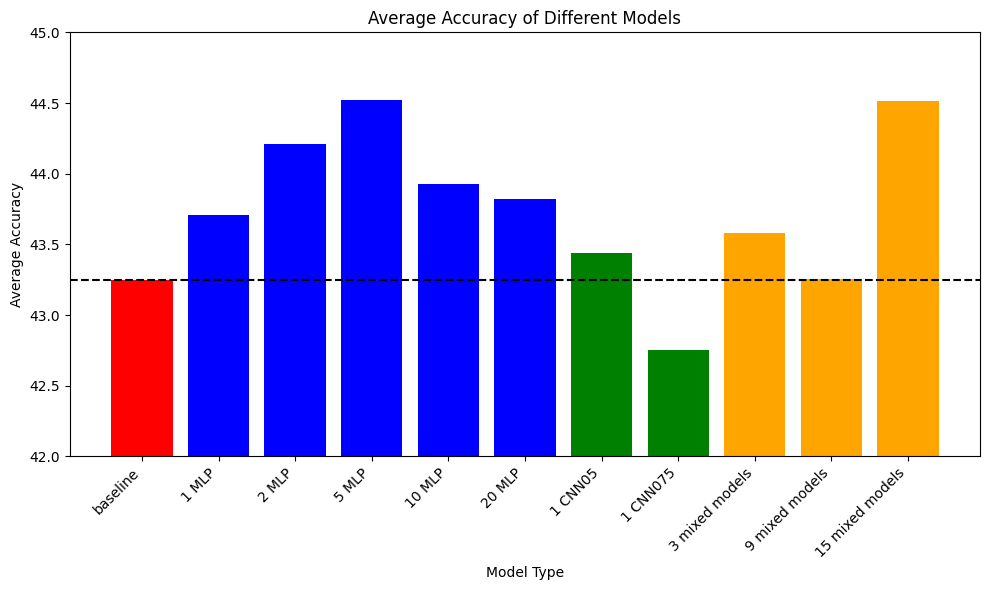

In [78]:
#@title Plotting results
plot1 = {}
for key in plot.keys():
    plot1[key] = np.mean(plot[key])

colors = []
for key in plot1.keys():
    if 'MLP' in key:
        colors.append('blue')
    elif 'CNN' in key:
        colors.append('green')
    elif 'mixed models' in key:
        colors.append('orange')
    else:
        colors.append('red')


baseline_value = plot1['baseline']
plt.figure(figsize=(10, 6))
bars = plt.bar(plot1.keys(), plot1.values(), color=colors)
plt.ylim(42, 45)
plt.axhline(y=baseline_value, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model Type')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy of Different Models')
plt.tight_layout()
plt.show()


So, the major improvements do not seem to me to depend, at least in this case, on the variety of teachers or their very high precision. Instead it seems very last to use models equal to the student and more spacious.

The observations made in the preceding paragraphs are confirmed, and a good number of teachers are identified in the $5$ range.

I find them very interesting results that go against what I thought but tell an interesting story. In fact it is evidently easier for a small MLP to imitate a big MLP than a big CNN. Perhaps, as the ages increased, CNN would have guaranteed better results due to its great accuracy. The same is true for the mixed ensemble of teacher models, since, as I shall illustrate below, this is much more precise.

But with the number of eras fixed at $10$ in all the notebook the best way to transfer information to a smaller network proved MTKD with $5$ teachers as I had assumed in the section dedicated to MTKD.

In [79]:
#@title Combined MLPs accuracy *

json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/combined_teacher_predictions.json'
if not saved_results:
    try:
        with open('combined_teacher_predictions.json', 'r') as json_file:
            Last_Teachers = json.load(json_file)
    except FileNotFoundError:
        Last_Teachers = {}

    combined_final_teachers = combine_teacher_predictions(teacher_modelsCIFAR, False, test_loaderCIFAR)
    print(combined_final_teachers)
    if 'combined_final_sameteachersCFIAR' not in Last_Teachers:
        Last_Teachers['combined_final_sameteachersCFIAR'] = combined_final_teachers
        with open('combined_teacher_predictions.json', 'w') as file:
            json.dump(Last_Teachers, file, indent=4)
else:
    try:
        response = requests.get(json_url)
        CT = response.json()
        print(f"Test accuracy: {CT['combined_final_sameteachersCFIAR']}%")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching JSON: {e}")


Test accuracy: 52.96%


In [80]:
#@title  Combined different models accuracy *

json_url = 'https://raw.github.com/FRAMAX444/Knowledge-Distillation/main/saved_results/combined_teacher_predictions.json'
if not saved_results:
    try:
        with open('combined_teacher_predictions.json', 'r') as json_file:
            Last_Teachers = json.load(json_file)
    except FileNotFoundError:
        Last_Teachers = {}

    combined_final_teachers = combine_teacher_predictions(teacher_modelsCIFAR_different, False, test_loaderCIFAR)
    print(combined_final_teachers)
    if 'combined_final_teachersCFIAR' not in Last_Teachers:
        Last_Teachers['combined_final_teachersCFIAR'] = combined_final_teachers
        with open('combined_teacher_predictions.json', 'w') as file:
            json.dump(Last_Teachers, file, indent=4)
else:
    try:
        response = requests.get(json_url)
        CT = response.json()
        print(f"Test accuracy: {CT['combined_final_teachersCFIAR']}%")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching JSON: {e}")

Test accuracy: 79.44%


### ***11. Citations***

**ARTICLES**

1.   Gou, J., Yu, B., Maybank, S. J., & Tao, D. (2021). *Knowledge distillation: a survey.* International Journal of Computer Vision, 129(6), 1789–1819. https://doi.org/10.1007/s11263-021-01453-z

2. Zuchniak, K. (2023, February 14). *Multi-teacher knowledge distillation as an effective method for compressing ensembles of neural networks.* arXiv.org. https://arxiv.org/abs/2302.07215

3.   Zhang, L., Song, J., Gao, A., Chen, J., Bao, C., & Ma, K. (2019, May 17). *Be your own teacher: Improve the performance of convolutional neural networks via self distillation.* arXiv.org. https://arxiv.org/abs/1905.08094

**WEBSITES**

4.   Alexandros Chariton(n.d.) *Knowledge Distillation Tutorial — PyTorch Tutorials 2.4.0+cu121 documentation. (n.d.).* https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html

5. Maddali, S. (2023, February 23). *What are Convolutional Neural Networks (CNN)?* - Nerd For Tech - Medium. Medium. https://medium.com/nerd-for-tech/what-are-convoluted-neural-networks-cnn-b207821fd665

6. Miranda, L. (2017, August 12). *Understanding softmax and the negative log-likelihood.* Lj Miranda. https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/

7. Misri, I. (2022, January 4). *How to set sampling temperature for GPT models - Isaac Misri - Medium. Medium.* https://medium.com/@imisri1/how-to-set-sampling-temperature-for-gpt-models-762887df1fac

8. Kurbiel, T. (2022, August 11). *Derivative of the Softmax function and the categorical Cross-Entropy loss. Medium.* https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1

**COURSES**

9.  Emanuele Rodolà (n.d.). *Machine Learning annual course for SMIA 2023/24* GitHub - erodola/ML-s2-2024. GitHub. https://github.com/erodola/ML-s2-2024

10.   MIT HAN Lab. (2023, October 6). *EfficientML.ai Lecture 9 - Knowledge Distillation (MIT 6.5940, Fall 2023, Zoom)* [Video]. YouTube. https://www.youtube.com/watch?v=dSDW_c789zI


